# Meat Production Data Cleaning

## Preparing
**Remark:** run preparing's codes anyway to initialate utilities.

Libraries:

In [2]:
"""Modules"""

import urllib.request, urllib.parse, urllib.error
import requests
from bs4 import BeautifulSoup

import lxml
import re
import os
import time
import datetime
import chardet
import zipfile
from zipfile import ZipFile
import json
from io import BytesIO

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.transforms
%matplotlib inline

import folium
from PIL import Image


import numpy as np
import pandas as pd

pd.set_option('precision', 4)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',100)

def curl(url,path,mode='wb'):
    response = urllib.request.urlopen(url).read()
    with open(path, mode) as handle:
        handle.write(response)

Setting

Define some functions data plot:

In [4]:
FIG_size=(6,16) # figure size

# font size
TIT_size = 16    # titles
LAB_size = 14    # labels
LEG_size = 14    # legends
TCK_size = 13    # ticklabels

LIN_wei = 2.5    # line weights
BAR_wid = 4      # bar width


CLs = ('darkgrey', 'r','b','y','c','g','m', 'k')    # clors
LSs = ('-', '--', ':', '-.', '-', '--', ':', '-.')  # linestyles

def setX_years(ax, ticks):
    ax.set_xticks(ticks)
    ax.set_xlim(ticks[0],ticks[-1])
    ax.set_xticklabels(ticks, rotation=45, ha='center', fontsize=TCK_size)
    ax.set_xlabel('Years', fontsize=LAB_size)
       
def setX_areas(ax, ticks):
    ax.set_xticklabels(ticks, rotation=90, ha='center', fontsize=TCK_size)
    ax.set_xlabel('Areas', fontsize=LAB_size)
    
def setY_num(ax, ticks):
    ax.set_yticks(ticks)
    ax.set_ylim(ticks[0],ticks[-1])
    ax.set_yticklabels(ticks, fontsize=TCK_size)
    ax.set_ylabel('Number (10000 #)', fontsize=LAB_size)
    
def setY_wei(ax, ticks):
    ax.set_yticks(ticks)
    ax.set_ylim(ticks[0],ticks[-1])
    ax.set_yticklabels(ticks, fontsize=TCK_size)
    ax.set_ylabel('Weight (10000 t)', fontsize=LAB_size)
    
def setY_per(ax):
    ticks=np.round(np.linspace(0.00, 1.00, num=11, endpoint=True), decimals=2)
    ax.set_yticks(ticks)
    ax.set_ylim(ticks[0],ticks[-1])
    ax.set_yticklabels(ticks, fontsize=TCK_size)
    ax.set_ylabel('Percentage (%)', fontsize=LAB_size)

def setSpi_LB(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

## Reading and Checking Raw Data

Raw Data: 

In [6]:
# raw
stk_fao = pd.read_csv('./data/FAO/Production_Livestock.csv')
prm_fao = pd.read_csv('./data/FAO/Production_LivestockPrimary.csv')
lvs_cn = pd.read_csv('./data/NBS/Production_Livestock.csv')
aqu_cn = pd.read_csv('./data/NBS/Production_Fish.csv')

dfs_raw = (stk_fao, prm_fao, lvs_cn, aqu_cn)

### Checking Data Updates
**Remark:** No need to run every time, 1 time a year is enough.

In [7]:
n=0
for df in dfs_raw:
    n+=1
    years = df['Year'].unique()
    years.sort()
    print('Year list of data No.{}  = {}'.format(n, years))

    year_newest = years.max()
    if year_newest == year_now-2:
        print("Tis data is already updated to year {}, the newest one.\n".format(year_now-2))
    else:
        print('The newest data is updated to year {}, while our data is updated to year{}'.format(year_now-2, year_newest))
print('If you want to update data, check README.md in this repository.')

Year list of data No.1  = [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017]
Tis data is already updated to year 2017, the newest one.

Year list of data No.2  = [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017]
Tis data is already updated to year 2017, the newest one.

Year list of data No.3  = [1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017]
Tis data is already updated to year 2017, the newest one.

Year list of data No.4  = [1978 1980 1985 1986 198

### Checking Data Frame
**Remark:** No need to run every time, just run when you want to check it.

In [8]:
n=0
for df in dfs_raw:
    n+=1
    print('Data No.{}:'.format(n))
    print('shape = {}'.format(df.shape))
    print('columns list = {}'.format(df.columns.tolist()))
    display(df.head())

Data No.1:
shape = (170682, 7)
columns list = ['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']


Area Code         Area Element   Item  Year  Unit      Value
0          2  Afghanistan  Stocks  Asses  1961  Head  1300000.0
1          2  Afghanistan  Stocks  Asses  1962  Head   851850.0
2          2  Afghanistan  Stocks  Asses  1963  Head  1001112.0
3          2  Afghanistan  Stocks  Asses  1964  Head  1150000.0
4          2  Afghanistan  Stocks  Asses  1965  Head  1300000.0

Data No.2:
shape = (1120815, 7)
columns list = ['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']


Area Code         Area Element                 Item  Year       Unit  \
0          2  Afghanistan  Laying  Eggs, hen, in shell  1961  1000 Head   
1          2  Afghanistan  Laying  Eggs, hen, in shell  1962  1000 Head   
2          2  Afghanistan  Laying  Eggs, hen, in shell  1963  1000 Head   
3          2  Afghanistan  Laying  Eggs, hen, in shell  1964  1000 Head   
4          2  Afghanistan  Laying  Eggs, hen, in shell  1965  1000 Head   

    Value  
0  4000.0  
1  4400.0  
2  4600.0  
3  4800.0  
4  5200.0

Data No.3:
shape = (642, 30)
columns list = ['Area', 'Year', 'Stock, large animals', 'Stock, cattle', 'Stock, horse', 'Stock, donkey', 'Stock, mule', 'Stock, camel', 'Slaughtered, pig', 'Stock, pig', 'Stock, goat & sheep', 'Stock, goat', 'Stock, sheep', 'Slaughtered, cattle', 'Slaughtered, goat & sheep', 'Slaughtered, birds', 'Meat Production, livestocks', 'Meat Production, pig, cattle, goat & sheep', 'Meat Production, pig', 'Meat Production, cattle', 'Meat Production, goat & sheep', 'Milk Production, total', 'Milk Production, cow', 'Wool Production, sheep', 'Wool Production, sheep, fine', 'Wool Production, sheep, semi-fine', 'Wool Production, goat, thick', 'Wool Production, goat, cashmere', 'Egg Production, birds', 'Honey Production']


Area  Year  Stock, large animals  Stock, cattle  Stock, horse  \
0  China, mainland  1996              13360.60       11031.80        871.50   
1  China, mainland  1997              14541.80       12175.70        891.20   
2  China, mainland  1998              14803.20       12441.90        898.10   
3  China, mainland  1999              15024.75       12698.34        891.41   
4  China, mainland  2000              15151.51       12866.34        876.58   

   Stock, donkey  Stock, mule  Stock, camel  Slaughtered, pig  Stock, pig  \
0         944.40       478.00         34.90          41225.10    36283.60   
1         952.80       480.60         35.00          46483.70    40034.80   
2         955.80       473.90         33.50          50215.10    42256.30   
3         934.77       467.27         32.96          51977.20    43144.20   
4         922.73       453.03         32.62          52673.34    44681.54   

   Stock, goat & sheep  Stock, goat  Stock, sheep  Slaughtered, cattle  \
0           23728.3000   12315.8000     11412.500                  NaN   
1           25575.7000   13480.1000     12091.900                  NaN   
2           26903.5000   14168.3000     12735.200                  NaN   
3           27925.7700   14816.2600     13109.500                  NaN   
4           29031.9007   15715.9277     13315.983                  NaN   

   Slaughtered, goat & sheep  Slaughtered, birds  Meat Production, livestocks  \
0                        NaN                 NaN                  4595.400000   
1                        NaN                 NaN                  5268.700000   
2                        NaN                 NaN                  5723.800000   
3                        NaN                 NaN                  5949.000000   
4                        NaN                 NaN                  6125.353545   

   Meat Production, pig, cattle, goat & sheep  Meat Production, pig  \
0                                 3694.700000           3158.000000   
1                                 4249.900000           3596.300000   
2                                 4598.200000           3883.700000   
3                                 4762.300000           4005.600000   
4                                 4838.193106           4031.429225   

   Meat Production, cattle  Meat Production, goat & sheep  \
0               355.700000                     181.000000   
1               440.900000                     212.800000   
2               479.900000                     234.600000   
3               505.429400                     251.264300   
4               532.805585                     273.958296   

   Milk Production, total  Milk Production, cow  Wool Production, sheep  \
0              735.800000             629.40000                298102.0   
1              681.100000             601.10000                255059.0   
2              745.400000             662.90000                277545.0   
3              806.907300             717.59390                283152.0   
4              919.118908             827.43079                292502.0   

   Wool Production, sheep, fine  Wool Production, sheep, semi-fine  \
0                      121020.0                            74099.0   
1                      116054.0                            55683.0   
2                      115752.0                            68775.0   
3                      114103.0                            73700.0   
4                      117386.0                            84921.0   

   Wool Production, goat, thick  Wool Production, goat, cashmere  \
0                       35255.0                          9585.00   
1                       25865.0                          8626.00   
2                       31417.0                          9799.00   
3                       31849.0                         10179.65   
4                       33266.0                         11057.00   

   Egg Production, birds  Honey Production  
0               1965.200

Data No.4:
shape = (675, 18)
columns list = ['Area', 'Year', 'Aquatic, total', 'Marine, total', 'Marine, capture', 'Marine, aquac.', 'Marine Fish', 'Marine Crustaceans', 'Marine Molluscs', 'Marine Plants', 'Marine, others', 'Freshwater, total', 'Freshwater, capture', 'Freshwater, aquac.', 'Freshwater Fish', 'Freshwater Crustaceans', 'Freshwater Molluscs', 'Freshwater, others']


Area  Year  Aquatic, total  Marine, total  Marine, capture  Marine, aquac.  \
0  CNFC  1998         27.4100        27.4100          27.4100             0.0   
1  CNFC  1999         18.3000        18.3000          18.3000             0.0   
2  CNFC  2000         17.5823        17.5823          17.5823             0.0   
3  CNFC  2001         18.2977        18.2977          18.2977             0.0   
4  CNFC  2002         18.2177        18.2177          18.2177             NaN   

   Marine Fish  Marine Crustaceans  Marine Molluscs  Marine Plants  \
0      25.1100              0.2000           0.1000            0.0   
1       9.5100              0.3200           8.4700            0.0   
2       7.7602              0.2194           9.6027            0.0   
3       8.9539              0.2250           9.1188            0.0   
4       9.6000              0.1000              NaN            NaN   

   Marine, others  Freshwater, total  Freshwater, capture  Freshwater, aquac.  \
0          2.0000                0.0                  0.0                 0.0   
1          0.0000                0.0                  0.0                 0.0   
2          0.0000                0.0                  0.0                 0.0   
3          0.0000                0.0                  0.0                 0.0   
4          8.4604                NaN                  NaN                 NaN   

   Freshwater Fish  Freshwater Crustaceans  Freshwater Molluscs  \
0              0.0                     0.0                  0.0   
1              0.0                     0.0                  0.0   
2              0.0                     0.0                  0.0   
3              0.0                     0.0                  0.0   
4              NaN                     NaN                  NaN   

   Freshwater, others  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 NaN

# First Glance at China's National Animal Production

## Data Outline

Merge Live Animals' Stock Data and Primary Data From FAO as China's National Product Data of Livestocks

In [9]:
stk_cn = stk_fao[stk_fao['Area']=='China, mainland']
prm_cn = prm_fao[prm_fao['Area']=='China, mainland']
display(stk_cn.groupby(['Element','Item']).count())
display(prm_cn.groupby(['Element','Item']).count())

Area Code  Area  Year  Unit  Value
Element Item                                                      
Stocks  Asses                          57    57    57    57     57
        Beehives                       57    57    57    57     57
        Buffaloes                      57    57    57    57     57
        Camels                         57    57    57    57     57
        Cattle                         57    57    57    57     57
        Cattle and Buffaloes           57    57    57    57     57
        Chickens                       57    57    57    57     57
        Ducks                          57    57    57    57     57
        Geese and guinea fowls         57    57    57    57     57
        Goats                          57    57    57    57     57
        Horses                         57    57    57    57     57
        Mules                          57    57    57    57     57
        Pigs                           57    57    57    57     57
        Poultry Birds                  57    57    57    57     57
        Rabbits and hares              57    57    57    57     57
        Sheep                          57    57    57    57     57
        Sheep and Goats                57    57    57    57     57

Area Code  \
Element                       Item                                             
Laying                        Eggs Primary                                57   
                              Eggs, hen, in shell                         57   
Milk Animals                  Milk, whole fresh buffalo                   57   
                              Milk, whole fresh camel                     57   
                              Milk, whole fresh cow                       57   
                              Milk, whole fresh goat                      57   
                              Milk, whole fresh sheep                     57   
                              Milk,Total                                  57   
Prod Popultn                  Honey, natural                              57   
Producing Animals/Slaughtered Beef and Buffalo Meat                       57   
                              Hides, buffalo, fresh                       53   
                              Hides, cattle, fresh                        53   
                              Meat, Poultry                               57   
                              Meat, ass                                   57   
                              Meat, buffalo                               57   
                              Meat, camel                                 57   
                              Meat, cattle                                57   
                              Meat, chicken                               57   
                              Meat, duck                                  57   
                              Meat, goat                                  57   
                              Meat, goose and guinea fowl                 57   
                              Meat, horse                                 57   
                              Meat, mule                                  57   
                              Meat, pig                                   57   
                              Meat, rabbit                                57   
                              Meat, sheep                                 57   
                              Sheep and Goat Meat                         57   
                              Skins, goat, fresh                          53   
                              Skins, sheep, fresh                         53   
Production                    Beef and Buffalo Meat                       57   
                              Eggs Primary                                57   
                              Eggs, hen, in shell                         57   
                              Eggs, hen, in shell (number)                57   
                              Eggs, other bird, in shell                  57   
                              Eggs, other bird, in shell (number)         57   
                              Hides, buffalo, fresh                       53   
                              Hides, cattle, fresh                        53   
                              Honey, natural                              57   
                              Meat indigenous, ass                       106   
                              Meat indigenous, buffalo                   106   
                              Meat indigenous, camel                     106   
                              Meat indigenous, cattle                    106   
                              Meat indigenous, chicken                   106   
                              Meat indigenous, duck                      106   
                              Meat indigenous, geese                     106   
                              Meat indigenous, goat                      106   
                              Meat indigenous, horse                     106   
                              Meat indigenous, mule                      106   
                              Meat indigenous, pig                 

In [10]:
lvs_fao_cn = pd.concat([stk_cn, prm_cn],join='outer')
print('shape of lvs_cn_raw is {}\nshape of stk_cn is {}\nshape of prm_cn is {}'.format(lvs_fao_cn.shape, stk_cn.shape, prm_cn.shape))
display(lvs_fao_cn.head())

shape of lvs_cn_raw is (8555, 7)
shape of stk_cn is (969, 7)
shape of prm_cn is (7586, 7)


Area Code             Area Element   Item  Year  Unit      Value
26574         41  China, mainland  Stocks  Asses  1961  Head  7527000.0
26575         41  China, mainland  Stocks  Asses  1962  Head  6565000.0
26576         41  China, mainland  Stocks  Asses  1963  Head  6454000.0
26577         41  China, mainland  Stocks  Asses  1964  Head  6746000.0
26578         41  China, mainland  Stocks  Asses  1965  Head  7048000.0

In [11]:
lvs_fao_cn = lvs_fao_cn.dropna()
lvs_fao_cn = lvs_fao_cn[~(lvs_fao_cn == 0).any(axis=1)]
print("Shape of China's National Product Raw Data of Livestocks", lvs_fao_cn.shape)
display(lvs_fao_cn.head())

Shape of China's National Product Raw Data of Livestocks (8503, 7)


Area Code             Area Element   Item  Year  Unit      Value
26574         41  China, mainland  Stocks  Asses  1961  Head  7527000.0
26575         41  China, mainland  Stocks  Asses  1962  Head  6565000.0
26576         41  China, mainland  Stocks  Asses  1963  Head  6454000.0
26577         41  China, mainland  Stocks  Asses  1964  Head  6746000.0
26578         41  China, mainland  Stocks  Asses  1965  Head  7048000.0

In [12]:
# Break Point - China's National Product Raw Data of Livestocks has saved
lvs_fao_cn.to_csv('./data/lvs_fao_cn_temp.csv', index=False)

## Select Elements and Items that Have Completed Records

### Select top elements by counting records.

In [13]:
lvs_fao_cn = pd.read_csv('./data/lvs_fao_cn_temp.csv')

print("Shape of China's National Product Data of Livestocks BEFORE selecting main records:", lvs_fao_cn.shape)
display(lvs_fao_cn.groupby('Element').count())

lvs_fao_cn = lvs_fao_cn[lvs_fao_cn['Element'].isin(['Stocks', 'Producing Animals/Slaughtered', 'Production', 'Yield/Carcass Weight'])]

print("Shape of China's National Product Data of Livestocks AFTER selecting main records:", lvs_fao_cn.shape)
display(lvs_fao_cn.groupby('Element').count())

Shape of China's National Product Data of Livestocks BEFORE selecting main records: (8503, 7)


Area Code  Area  Item  Year  Unit  Value
Element                                                                
Laying                               114   114   114   114   114    114
Milk Animals                         342   342   342   342   342    342
Prod Popultn                          57    57    57    57    57     57
Producing Animals/Slaughtered       1124  1124  1124  1124  1124   1124
Production                          3571  3571  3571  3571  3571   3571
Stocks                               969   969   969   969   969    969
Yield                                725   725   725   725   725    725
Yield/Carcass Weight                1601  1601  1601  1601  1601   1601

Shape of China's National Product Data of Livestocks AFTER selecting main records: (7265, 7)


Area Code  Area  Item  Year  Unit  Value
Element                                                                
Producing Animals/Slaughtered       1124  1124  1124  1124  1124   1124
Production                          3571  3571  3571  3571  3571   3571
Stocks                               969   969   969   969   969    969
Yield/Carcass Weight                1601  1601  1601  1601  1601   1601

### Select main items that have fully records by counting

In [14]:
print("Shape of China's National Product Data of Livestocks BEFORE selecting fully recorded records:", lvs_cn.shape)
display(lvs_fao_cn.groupby(['Element', 'Item']).count())

lrg_st=['Cattle', 'Camels', 'Horses']
mid_st=['Pigs', 'Sheep', 'Goats']
brd_st=['Chickens', 'Ducks', 'Geese and guinea fowls']

lrg_mt=['Meat, cattle', 'Meat, camel', 'Meat, horse']
mid_mt=['Meat, pig', 'Meat, sheep', 'Meat, goat']
brd_mt=['Meat, chicken', 'Meat, duck', 'Meat, goose and guinea fowl']

egg=['Eggs, hen, in shell', 'Eggs, other bird, in shell']
mlk=['Milk, whole fresh cow','Milk, whole fresh camel','Milk, whole fresh sheep','Milk, whole fresh goat']

lvs_fao_cn = lvs_fao_cn.loc[lvs_fao_cn['Item'].isin(lrg_st+mid_st+brd_st + lrg_mt+mid_mt+brd_mt + egg+mlk)]

print("Shape of China's National Product Data of Livestocks AFTER selecting fully recorded records:", lvs_fao_cn.shape)
display(lvs_fao_cn.groupby(['Element', 'Item']).count())

Shape of China's National Product Data of Livestocks BEFORE selecting fully recorded records: (642, 30)


Area Code  \
Element                       Item                                             
Producing Animals/Slaughtered Beef and Buffalo Meat                       57   
                              Hides, buffalo, fresh                       53   
                              Hides, cattle, fresh                        53   
                              Meat, Poultry                               57   
                              Meat, ass                                   57   
                              Meat, buffalo                               57   
                              Meat, camel                                 57   
                              Meat, cattle                                57   
                              Meat, chicken                               57   
                              Meat, duck                                  57   
                              Meat, goat                                  57   
                              Meat, goose and guinea fowl                 57   
                              Meat, horse                                 57   
                              Meat, mule                                  57   
                              Meat, pig                                   57   
                              Meat, rabbit                                57   
                              Meat, sheep                                 57   
                              Sheep and Goat Meat                         57   
                              Skins, goat, fresh                          53   
                              Skins, sheep, fresh                         53   
Production                    Beef and Buffalo Meat                       57   
                              Eggs Primary                                57   
                              Eggs, hen, in shell                         57   
                              Eggs, hen, in shell (number)                57   
                              Eggs, other bird, in shell                  57   
                              Eggs, other bird, in shell (number)         57   
                              Hides, buffalo, fresh                       53   
                              Hides, cattle, fresh                        53   
                              Honey, natural                              57   
                              Meat indigenous, ass                       106   
                              Meat indigenous, buffalo                   106   
                              Meat indigenous, camel                     106   
                              Meat indigenous, cattle                    106   
                              Meat indigenous, chicken                   106   
                              Meat indigenous, duck                      106   
                              Meat indigenous, geese                     106   
                              Meat indigenous, goat                      106   
                              Meat indigenous, horse                     106   
                              Meat indigenous, mule                      106   
                              Meat indigenous, pig                       106   
                              Meat indigenous, poultry                   106   
                              Meat indigenous, rabbit                    106   
                              Meat indigenous, sheep                     106   
                              Meat indigenous, total                      53   
                              Meat, Poultry                               57   
                              Meat, Total                                 57   
                              Meat, ass                                   57   
                              Meat, buffalo                               57   
                              Meat, camel                          

Shape of China's National Product Data of Livestocks AFTER selecting fully recorded records: (2394, 7)


Area Code  Area  \
Element                       Item                                           
Producing Animals/Slaughtered Meat, camel                         57    57   
                              Meat, cattle                        57    57   
                              Meat, chicken                       57    57   
                              Meat, duck                          57    57   
                              Meat, goat                          57    57   
                              Meat, goose and guinea fowl         57    57   
                              Meat, horse                         57    57   
                              Meat, pig                           57    57   
                              Meat, sheep                         57    57   
Production                    Eggs, hen, in shell                 57    57   
                              Eggs, other bird, in shell          57    57   
                              Meat, camel                         57    57   
                              Meat, cattle                        57    57   
                              Meat, chicken                       57    57   
                              Meat, duck                          57    57   
                              Meat, goat                          57    57   
                              Meat, goose and guinea fowl         57    57   
                              Meat, horse                         57    57   
                              Meat, pig                           57    57   
                              Meat, sheep                         57    57   
                              Milk, whole fresh camel             57    57   
                              Milk, whole fresh cow               57    57   
                              Milk, whole fresh goat              57    57   
                              Milk, whole fresh sheep             57    57   
Stocks                        Camels                              57    57   
                              Cattle                              57    57   
                              Chickens                            57    57   
                              Ducks                               57    57   
                              Geese and guinea fowls              57    57   
                              Goats                               57    57   
                              Horses                              57    57   
                              Pigs                                57    57   
                              Sheep                               57    57   
Yield/Carcass Weight          Meat, camel                         57    57   
                              Meat, cattle                        57    57   
                              Meat, chicken                       57    57   
                              Meat, duck                          57    57   
                              Meat, goat                          57    57   
                              Meat, goose and guinea fowl         57    57   
                              Meat, horse                         57    57   
                              Meat, pig                           57    57   
                              Meat, sheep                         57    57   

                                                           Year  Unit  Value  
Element                       Item                                            
Producing Animals/Slaughtered Meat, camel                    57    57     57  
                              Meat, cattle                   57    57     57  
                              Meat, chicken                  57    57     57  
                              Meat, duck                     57    57     57  
                              Meat, goat                     57    57     57  
                              Meat, goose and guinea fowl    57    57    

## Uniform Units

In [15]:
# print('Units BEFORE uniform')
# display(lvs_cn.groupby(['Element', 'Unit']).count())

lvs_fao_cn.loc[lvs_fao_cn['Unit'] =='Head','Value']=lvs_fao_cn['Value']/10000
lvs_fao_cn.loc[lvs_fao_cn['Unit']=='Head', 'Unit']= '10000 Head'

lvs_fao_cn.loc[lvs_fao_cn['Unit'] =='1000 Head','Value']=lvs_fao_cn['Value']/10
lvs_fao_cn.loc[lvs_fao_cn['Unit']=='1000 Head', 'Unit']= '10000 Head'

lvs_fao_cn.loc[lvs_fao_cn['Unit'] =='tonnes','Value']=lvs_fao_cn['Value']/10000
lvs_fao_cn.loc[lvs_fao_cn['Unit']=='tonnes', 'Unit']= '10000 tonnes'

lvs_fao_cn.loc[lvs_fao_cn['Unit'] =='hg/An','Value']=lvs_fao_cn['Value']/10
lvs_fao_cn.loc[lvs_fao_cn['Unit']=='hg/An', 'Unit']= 'kg/An'

lvs_fao_cn.loc[lvs_fao_cn['Unit'] =='0.1g/An','Value']=lvs_fao_cn['Value']/10000
lvs_fao_cn.loc[lvs_fao_cn['Unit']=='0.1g/An', 'Unit']= 'kg/An'

print('Units AFTER uniform')
display(lvs_fao_cn.groupby(['Element', 'Unit']).count())

Units AFTER uniform


Area Code  Area  Item  Year  Value
Element                       Unit                                            
Producing Animals/Slaughtered 10000 Head          513   513   513   513    513
Production                    10000 tonnes        855   855   855   855    855
Stocks                        10000 Head          513   513   513   513    513
Yield/Carcass Weight          kg/An               513   513   513   513    513

In [16]:
# Break Point - China's National Product Data of Livestocks after selecting main records.
lvs_fao_cn.to_csv('./data/lvs_fao_cn_temp.csv', index=False)

## Explore Data for a Further Data Selection

In [17]:
lvs_fao_cn = pd.read_csv('./data/lvs_fao_cn_temp.csv')

# years for ploting charts
years = list(range(1965,2020,5))
Xs = range(1960, 2025, 5)

def plotLine(dfs, items):
    for n in range(0, len(items)):
        dfs[items[n]].plot.line(x='Year', c=CLs[n], ls=LSs[n], lw=LIN_wei, ax=ax0)
    
    ax=plt.gca()
    ax.legend(labels=list(items), loc='center left', frameon=False, fontsize=LEG_size,
           bbox_to_anchor=(1.1,0.5),borderaxespad = 0.)
    setSpi_LB(ax)
    setX_years(ax, Xs)
    
def plotBar(dfs, items):
    bot = np.zeros(len(years))
    for n in range(0, len(items)):
        plt.bar(years, np.array(dfs[items[n]][dfs[items[n]]['Year'].isin(years)]['Value']),bottom=bot,color=CLs[n], width=BAR_wid)
        bot=bot + np.array(dfs[items[n]][dfs[items[n]]['Year'].isin(years)]['Value'])

    ax=plt.gca()
    ax.legend(labels=list(items), loc='center left', frameon=False, fontsize=LEG_size,
           bbox_to_anchor=(1.1,0.5),borderaxespad = 0.)
    setSpi_LB(ax)
    setX_years(ax, Xs)
    
    return bot

def plotStackBar(dfs, items):
    year_total
    bot = np.zeros(len(years))
    for n in range(0, len(items)):
        plt.bar(years, np.array(dfs[items[n]][dfs[items[n]]['Year'].isin(years)]['Value'])/year_total,bottom=bot,color=CLs[n], width=BAR_wid)
        bot=bot + np.array(dfs[items[n]][dfs[items[n]]['Year'].isin(years)]['Value'])/year_total
    
    ax=plt.gca()
    ax.legend(labels=list(items), loc='center left', frameon=False, fontsize=LEG_size,
               bbox_to_anchor=(1.1,0.5),borderaxespad = 0.)
    setSpi_LB(ax)
    setX_years(ax, Xs)

### Animal Stocks

In [18]:
# animals we' chosen for this part as mentioned above
lrg_st=['Cattle', 'Camels', 'Horses']
mid_st=['Pigs', 'Sheep', 'Goats']
brd_st=['Chickens', 'Ducks', 'Geese and guinea fowls']

# data frame for this part
st = lvs_fao_cn[(lvs_fao_cn['Element']=='Stocks')][['Year','Item','Value']]

#### Large Animal Stocks

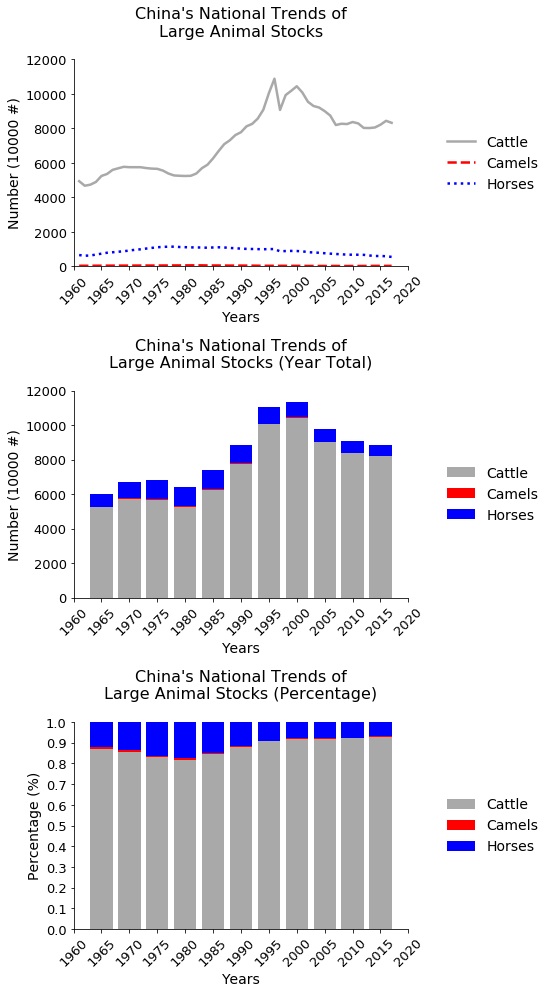

In [19]:
fig = plt.figure(figsize = FIG_size)
fig.tight_layout()                        
plt.subplots_adjust(wspace=0., hspace =0.6)

title = 'Large Animal Stocks'
title1 = "China's National Trends of\n"+title+"\n"
title2 = "China's National Trends of\n"+title+" (Year Total)\n"
title3 = "China's National Trends of\n"+title+" (Percentage)\n"

items = lrg_st
dfs = {}
for n in range(0, len(items)):
    dfs[items[n]] = st[st['Item']==items[n]].sort_values(['Year'], ascending=True, axis=0)

# ------------------------------------------------------------------------------------------------
ax0 = fig.add_subplot(3,1,1)
plt.title(title1, fontsize=TIT_size)
plotLine(dfs, items)
setY_num(ax0, range(0, 14000, 2000))

ax1 = fig.add_subplot(3,1,2)
plt.title(title2, fontsize=TIT_size)
year_total=plotBar(dfs, items)
setY_num(ax1, range(0, 14000, 2000))

ax2 = fig.add_subplot(3,1,3)
plt.title(title3, fontsize=TIT_size)
plotStackBar(dfs, items)
setY_per(ax2)

plt.show()

#### Pig, Goat and Sheep Stocks

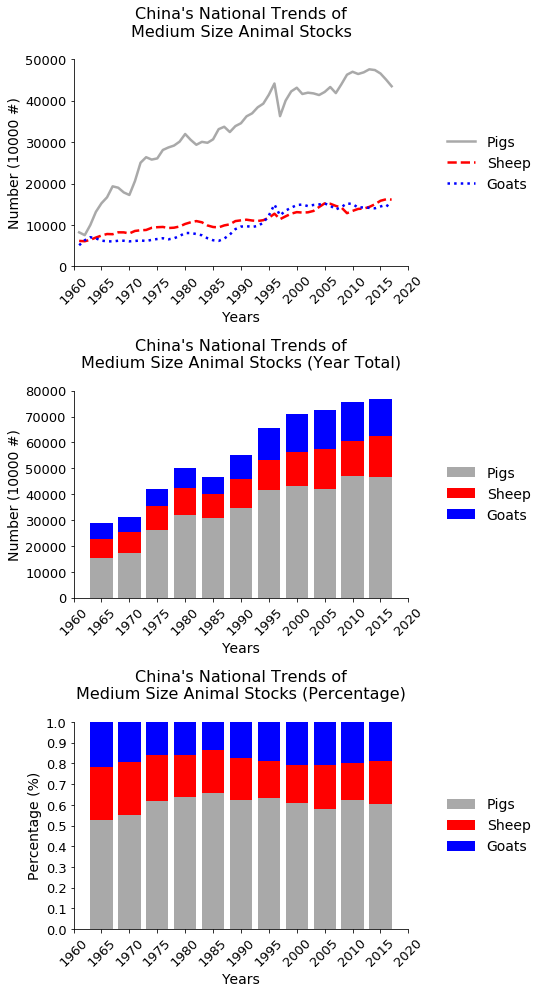

In [20]:
fig = plt.figure(figsize = FIG_size)
fig.tight_layout()                        
plt.subplots_adjust(wspace=0., hspace =0.6)

title = 'Medium Size Animal Stocks'
title1 = "China's National Trends of\n"+title+"\n"
title2 = "China's National Trends of\n"+title+" (Year Total)\n"
title3 = "China's National Trends of\n"+title+" (Percentage)\n"

items = mid_st
dfs = {}
for n in range(0, len(items)):
    dfs[items[n]] = st[st['Item']==items[n]].sort_values(['Year'], ascending=True, axis=0)
    
# -------------------------------------------------------------------------------------------
ax0 = fig.add_subplot(3,1,1)
plt.title(title1, fontsize=TIT_size)
plotLine(dfs, items)
setY_num(ax0, range(0, 60000, 10000))

ax1 = fig.add_subplot(3,1,2)
plt.title(title2, fontsize=TIT_size)
year_total=plotBar(dfs, items)
setY_num(ax1, range(0, 90000, 10000))

ax2 = fig.add_subplot(3,1,3)
plt.title(title3, fontsize=TIT_size)
plotStackBar(dfs, items)
setY_per(ax2)

plt.show()

#### Birds Stocks

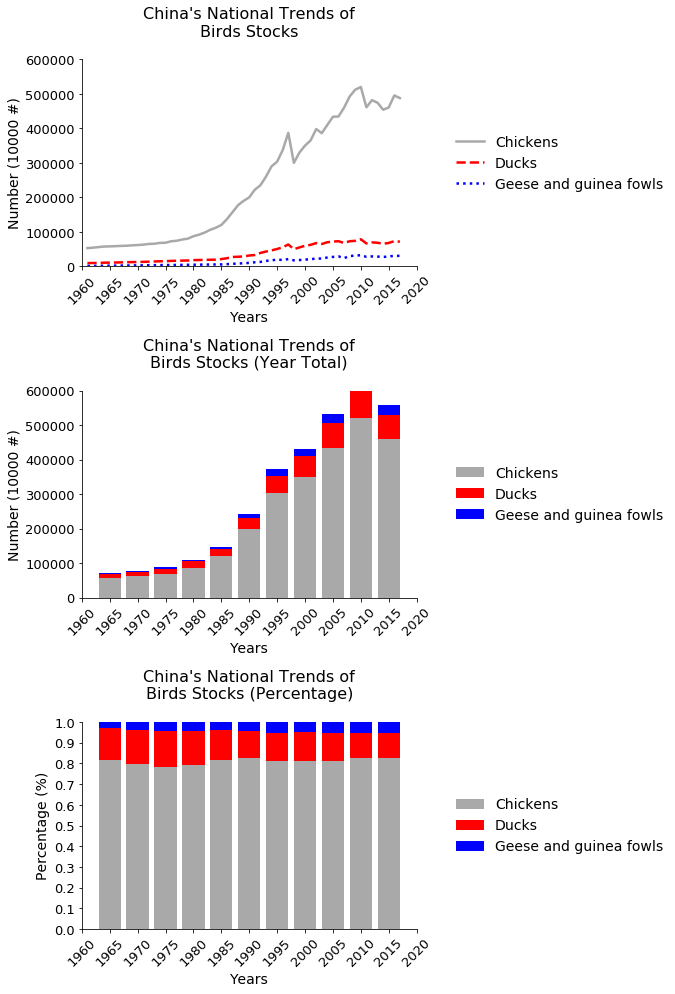

In [21]:
fig = plt.figure(figsize = FIG_size)
fig.tight_layout()                        
plt.subplots_adjust(wspace=0., hspace =0.6)

title = 'Birds Stocks'
title1 = "China's National Trends of\n"+title+"\n"
title2 = "China's National Trends of\n"+title+" (Year Total)\n"
title3 = "China's National Trends of\n"+title+" (Percentage)\n"

items = brd_st
dfs = {}
for n in range(0, len(items)):
    dfs[items[n]] = st[st['Item']==items[n]].sort_values(['Year'], ascending=True, axis=0)
    
# -------------------------------------------------------------------------------------------
ax0 = fig.add_subplot(3,1,1)
plt.title(title1, fontsize=TIT_size)
plotLine(dfs, items)
setY_num(ax0, range(0, 700000, 100000))

ax1 = fig.add_subplot(3,1,2)
plt.title(title2, fontsize=TIT_size)
year_total=plotBar(dfs, items)
setY_num(ax1, range(0, 700000, 100000))

ax2 = fig.add_subplot(3,1,3)
plt.title(title3, fontsize=TIT_size)
plotStackBar(dfs, items)
setY_per(ax2)

plt.show()

### Slaughtered Animals

In [22]:
lrg_mt=['Meat, cattle', 'Meat, camel', 'Meat, horse']
mid_mt=['Meat, pig', 'Meat, sheep', 'Meat, goat']
brd_mt=['Meat, chicken', 'Meat, duck', 'Meat, goose and guinea fowl']

sl=lvs_fao_cn[(lvs_fao_cn['Element']=='Producing Animals/Slaughtered')][['Year','Item','Value']]

#### Slaughtered Large Animals

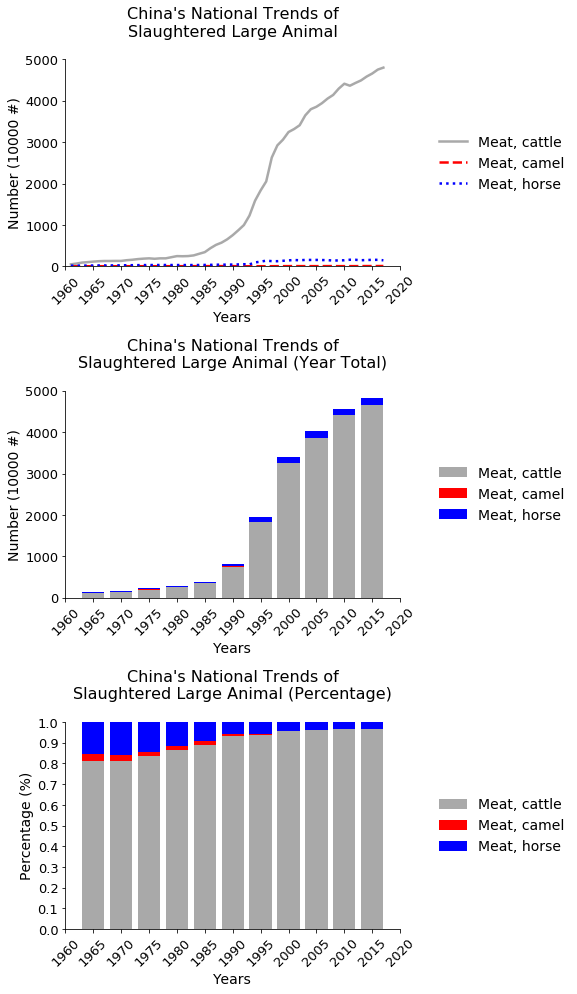

In [23]:
fig = plt.figure(figsize = FIG_size)
fig.tight_layout()                        
plt.subplots_adjust(wspace=0., hspace =0.6)

title = 'Slaughtered Large Animal'
title1 = "China's National Trends of\n"+title+"\n"
title2 = "China's National Trends of\n"+title+" (Year Total)\n"
title3 = "China's National Trends of\n"+title+" (Percentage)\n"

items = lrg_mt
dfs = {}
for n in range(0, len(items)):
    dfs[items[n]] = sl[sl['Item']==items[n]].sort_values(['Year'], ascending=True, axis=0)

    
# -------------------------------------------------------------------------------------------
ax0 = fig.add_subplot(3,1,1)
plt.title(title1, fontsize=TIT_size)
plotLine(dfs, items)
setY_num(ax0, range(0, 6000, 1000))

ax1 = fig.add_subplot(3,1,2)
plt.title(title2, fontsize=TIT_size)
year_total=plotBar(dfs, items)
setY_num(ax1, range(0, 6000, 1000))

ax2 = fig.add_subplot(3,1,3)
plt.title(title3, fontsize=TIT_size)
plotStackBar(dfs, items)
setY_per(ax2)

plt.show()

#### Slaughtered Medium Size Animals

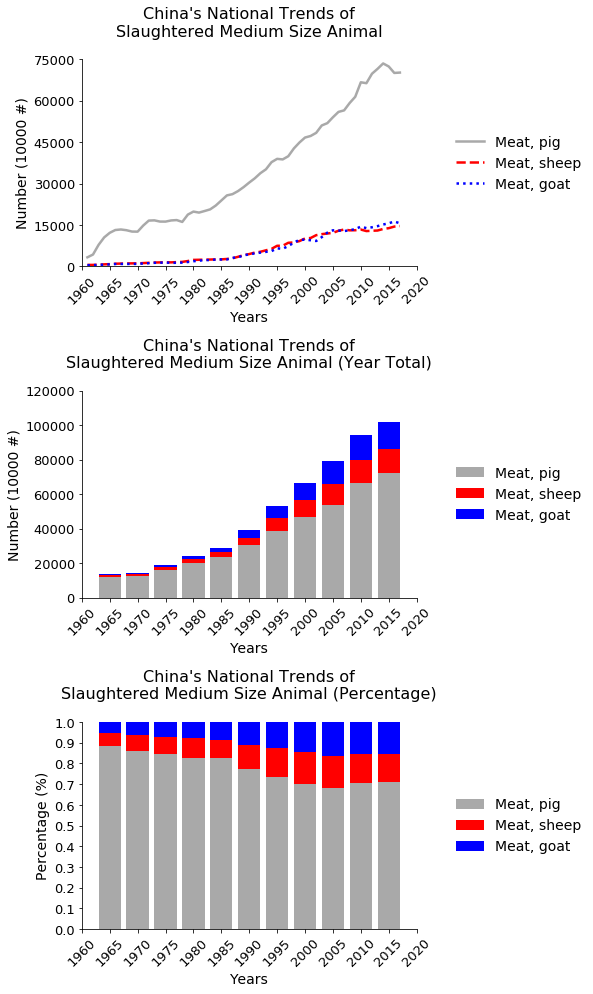

In [24]:
fig = plt.figure(figsize = FIG_size)
fig.tight_layout()                        
plt.subplots_adjust(wspace=0., hspace =0.6)

title = 'Slaughtered Medium Size Animal'
title1 = "China's National Trends of\n"+title+"\n"
title2 = "China's National Trends of\n"+title+" (Year Total)\n"
title3 = "China's National Trends of\n"+title+" (Percentage)\n"

items = mid_mt
dfs = {}
for n in range(0, len(items)):
    dfs[items[n]] = sl[sl['Item']==items[n]].sort_values(['Year'], ascending=True, axis=0)
    
# -------------------------------------------------------------------------------------------
ax0 = fig.add_subplot(3,1,1)
plt.title(title1, fontsize=TIT_size)
plotLine(dfs, items)
setY_num(ax0, range(0, 90000, 15000))

ax1 = fig.add_subplot(3,1,2)
plt.title(title2, fontsize=TIT_size)
year_total=plotBar(dfs, items)
setY_num(ax1, range(0, 140000, 20000))

ax2 = fig.add_subplot(3,1,3)
plt.title(title3, fontsize=TIT_size)
plotStackBar(dfs, items)
setY_per(ax2)

plt.show()

#### Slaughtered Birds

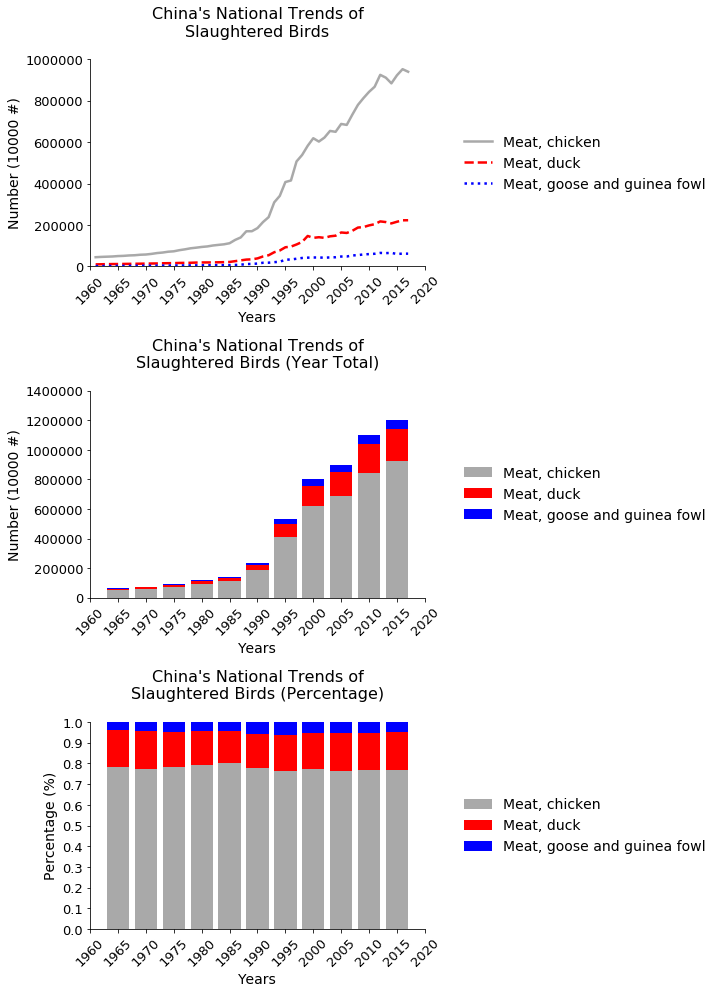

In [25]:
fig = plt.figure(figsize = FIG_size)
fig.tight_layout()                        
plt.subplots_adjust(wspace=0., hspace =0.6)

title = 'Slaughtered Birds'
title1 = "China's National Trends of\n"+title+"\n"
title2 = "China's National Trends of\n"+title+" (Year Total)\n"
title3 = "China's National Trends of\n"+title+" (Percentage)\n"

items = brd_mt
dfs = {}
for n in range(0, len(items)):
    dfs[items[n]] = sl[sl['Item']==items[n]].sort_values(['Year'], ascending=True, axis=0)
# -------------------------------------------------------------------------------------------
ax0 = fig.add_subplot(3,1,1)
plt.title(title1, fontsize=TIT_size)
plotLine(dfs, items)
setY_num(ax0, range(0, 1200000, 200000))

ax1 = fig.add_subplot(3,1,2)
plt.title(title2, fontsize=TIT_size)
year_total=plotBar(dfs, items)
setY_num(ax1, range(0, 1600000, 200000))

ax2 = fig.add_subplot(3,1,3)
plt.title(title3, fontsize=TIT_size)
plotStackBar(dfs, items)
setY_per(ax2)

plt.show()

### Production of Animal Products

After Exploring the Stocks and Slaughtered animals, we know that the main kinds of animals for animal products include: Cattles, Goats, Sheep, Pigs, Chickens, and ducks, because The sum of the number of these animal stocks or the number of slaughters exceeds 90% of those of the equivalent body size.

So, the main kind of animal production should include: meat of cattle, meat of goat, meat of sheep, meat of pig, meat of chicken, and meat of duck, egg from hen and other birds, and cow milk.

In [26]:
meat_pr = ['Meat, cattle', 'Meat, sheep', 'Meat, goat', 'Meat, pig', 'Meat, chicken', 'Meat, duck']
egg_mlk=['Eggs, hen, in shell', 'Eggs, other bird, in shell','Milk, whole fresh cow']

prod = lvs_fao_cn[(lvs_fao_cn['Element']=='Production')][['Year','Item','Value']]

#### Productions of Animal Meat

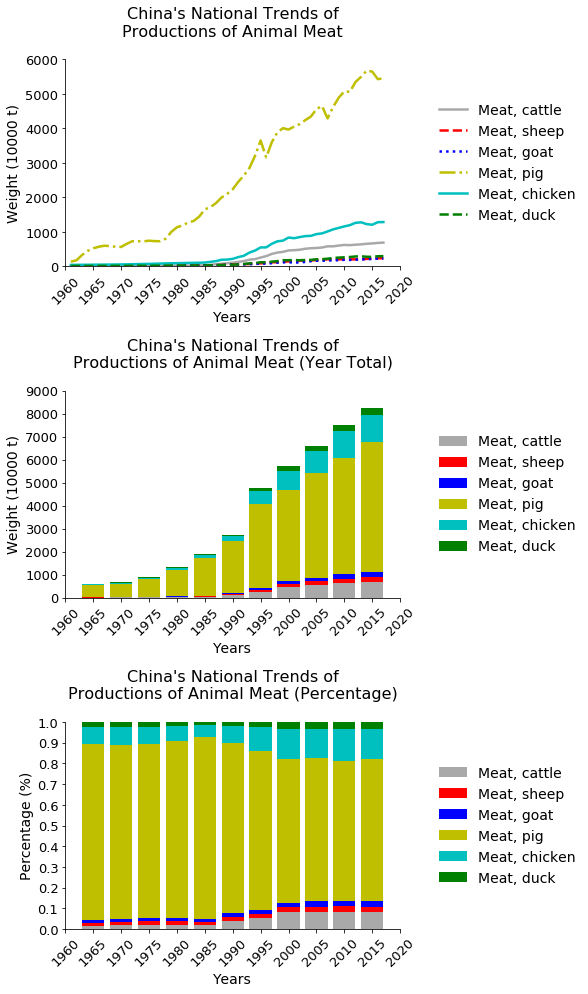

In [27]:
fig = plt.figure(figsize = FIG_size)
fig.tight_layout()                        
plt.subplots_adjust(wspace=0., hspace =0.6)

title = 'Productions of Animal Meat'
title1 = "China's National Trends of\n"+title+"\n"
title2 = "China's National Trends of\n"+title+" (Year Total)\n"
title3 = "China's National Trends of\n"+title+" (Percentage)\n"

items = meat_pr
dfs = {}
for n in range(0, len(items)):
    dfs[items[n]] = prod[prod['Item']==items[n]].sort_values(['Year'], ascending=True, axis=0)
# -------------------------------------------------------------------------------------------
ax0 = fig.add_subplot(3,1,1)
plt.title(title1, fontsize=TIT_size)
plotLine(dfs, items)
setY_wei(ax0, range(0, 7000, 1000))

ax1 = fig.add_subplot(3,1,2)
plt.title(title2, fontsize=TIT_size)
year_total=plotBar(dfs, items)
setY_wei(ax1, range(0, 10000, 1000))

ax2 = fig.add_subplot(3,1,3)
plt.title(title3, fontsize=TIT_size)
plotStackBar(dfs, items)
setY_per(ax2)

plt.show()

#### Production of Birds Egg and Cow Milk

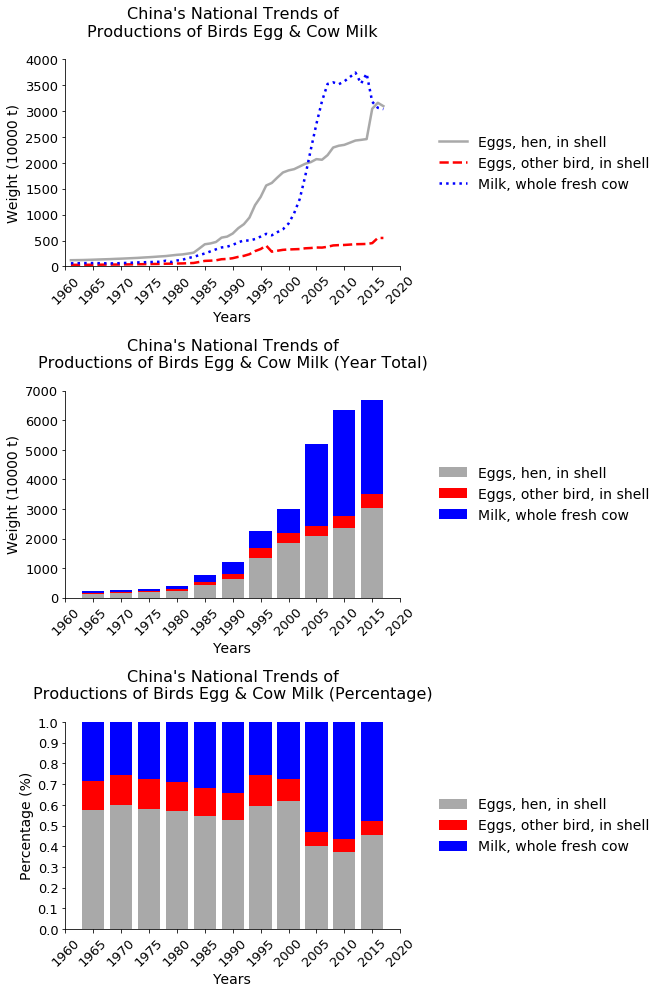

In [28]:
fig = plt.figure(figsize = FIG_size)
fig.tight_layout()                        
plt.subplots_adjust(wspace=0., hspace =0.6)

title = 'Productions of Birds Egg & Cow Milk'
title1 = "China's National Trends of\n"+title+"\n"
title2 = "China's National Trends of\n"+title+" (Year Total)\n"
title3 = "China's National Trends of\n"+title+" (Percentage)\n"

items = egg_mlk
dfs = {}
for n in range(0, len(items)):
    dfs[items[n]] = prod[prod['Item']==items[n]].sort_values(['Year'], ascending=True, axis=0)
# -------------------------------------------------------------------------------------------
ax0 = fig.add_subplot(3,1,1)
plt.title(title1, fontsize=TIT_size)
plotLine(dfs, items)
setY_wei(ax0, range(0, 4500, 500))


ax1 = fig.add_subplot(3,1,2)
plt.title(title2, fontsize=TIT_size)
year_total=plotBar(dfs, items)
setY_wei(ax1, range(0, 8000, 1000))

ax2 = fig.add_subplot(3,1,3)
plt.title(title3, fontsize=TIT_size)
plotStackBar(dfs, items)
setY_per(ax2)

plt.show()

## Clean Data Further

In [29]:
stocks = ['Cattle', 'Goats', 'Sheep', 'Pigs', 'Chickens', 'Ducks']
meat=['Meat, cattle', 'Meat, goat', 'Meat, sheep', 'Meat, pig', 'Meat, chicken', 'Meat, duck']
egg_mlk=['Eggs, hen, in shell', 'Eggs, other bird, in shell', 'Milk, whole fresh cow']

lvs_fao_cn = lvs_fao_cn[lvs_fao_cn['Item'].isin(stocks+meat+egg_mlk)]

print("Shape of China's National Product Data of Livestocks after feature selecting:", lvs_fao_cn.shape)
display(lvs_fao_cn.groupby(['Element', 'Item']).count())

Shape of China's National Product Data of Livestocks after feature selecting: (1539, 7)


Area Code  Area  \
Element                       Item                                          
Producing Animals/Slaughtered Meat, cattle                       57    57   
                              Meat, chicken                      57    57   
                              Meat, duck                         57    57   
                              Meat, goat                         57    57   
                              Meat, pig                          57    57   
                              Meat, sheep                        57    57   
Production                    Eggs, hen, in shell                57    57   
                              Eggs, other bird, in shell         57    57   
                              Meat, cattle                       57    57   
                              Meat, chicken                      57    57   
                              Meat, duck                         57    57   
                              Meat, goat                         57    57   
                              Meat, pig                          57    57   
                              Meat, sheep                        57    57   
                              Milk, whole fresh cow              57    57   
Stocks                        Cattle                             57    57   
                              Chickens                           57    57   
                              Ducks                              57    57   
                              Goats                              57    57   
                              Pigs                               57    57   
                              Sheep                              57    57   
Yield/Carcass Weight          Meat, cattle                       57    57   
                              Meat, chicken                      57    57   
                              Meat, duck                         57    57   
                              Meat, goat                         57    57   
                              Meat, pig                          57    57   
                              Meat, sheep                        57    57   

                                                          Year  Unit  Value  
Element                       Item                                           
Producing Animals/Slaughtered Meat, cattle                  57    57     57  
                              Meat, chicken                 57    57     57  
                              Meat, duck                    57    57     57  
                              Meat, goat                    57    57     57  
                              Meat, pig                     57    57     57  
                              Meat, sheep                   57    57     57  
Production                    Eggs, hen, in shell           57    57     57  
                              Eggs, other bird, in shell    57    57     57  
                              Meat, cattle                  57    57     57  
                              Meat, chicken                 57    57     57  
                              Meat, duck                    57    57     57  
                              Meat, goat                    57    57     57  
                              Meat, pig                     57    57     57  
                              Meat, sheep                   57    57     57  
                              Milk, whole fresh cow         57    57     57  
Stocks                        Cattle                        57    57     57  
                              Chickens                      57    57     57  
                              Ducks                         57    57     57  
                              Goats                         57    57     57  
                              Pigs                          57    57     57  
                              Sheep                         57    57     57  
Yield/Carcass Weight          

Save data.

In [30]:
# Break Point - China's National Product Data of Livestocks after features selecting.
lvs_fao_cn.to_csv('./data/lvs_fao_cn_temp.csv', index=False)

# First Glance at Land Animal Productions in Different Areas of China

### Data Outline

In [31]:
lvs_cn_ars = pd.read_csv('.data/NBS/Production_Livestock.csv')

print('There are {} rows and {} columns in the data frame.\n'.format(lvs_cn_ars.shape[0],lvs_cn_ars.shape[1]))

items = lvs_cn_ars.columns.values.tolist()
print('Items list =', items, '\n')

areas = lvs_cn_ars['Area'].unique()
print('Areas list =',areas, '\n')

There are 642 rows and 30 columns in the data frame.

Items list = ['Area', 'Year', 'Stock, large animals', 'Stock, cattle', 'Stock, horse', 'Stock, donkey', 'Stock, mule', 'Stock, camel', 'Slaughtered, pig', 'Stock, pig', 'Stock, goat & sheep', 'Stock, goat', 'Stock, sheep', 'Slaughtered, cattle', 'Slaughtered, goat & sheep', 'Slaughtered, birds', 'Meat Production, livestocks', 'Meat Production, pig, cattle, goat & sheep', 'Meat Production, pig', 'Meat Production, cattle', 'Meat Production, goat & sheep', 'Milk Production, total', 'Milk Production, cow', 'Wool Production, sheep', 'Wool Production, sheep, fine', 'Wool Production, sheep, semi-fine', 'Wool Production, goat, thick', 'Wool Production, goat, cashmere', 'Egg Production, birds', 'Honey Production'] 

Areas list = ['China, mainland' 'Beijing' 'Tianjin' 'Hebei' 'Shanxi' 'Neimenggu'
 'Liaoning' 'Jilin' 'Heilongjiang' 'Shanghai' 'Jiangsu' 'Zhejiang' 'Anhui'
 'Fujian' 'Jiangxi' 'Shandong' 'Henan' 'Hubei' 'Hunan' 'Guangdong'
 'Guan

In [32]:
display(lvs_cn_ars.head())
display(lvs_cn_ars.tail())

Area  Year  Stock, large animals  Stock, cattle  Stock, horse  \
0  China, mainland  1996              13360.60       11031.80        871.50   
1  China, mainland  1997              14541.80       12175.70        891.20   
2  China, mainland  1998              14803.20       12441.90        898.10   
3  China, mainland  1999              15024.75       12698.34        891.41   
4  China, mainland  2000              15151.51       12866.34        876.58   

   Stock, donkey  Stock, mule  Stock, camel  Slaughtered, pig  Stock, pig  \
0         944.40       478.00         34.90          41225.10    36283.60   
1         952.80       480.60         35.00          46483.70    40034.80   
2         955.80       473.90         33.50          50215.10    42256.30   
3         934.77       467.27         32.96          51977.20    43144.20   
4         922.73       453.03         32.62          52673.34    44681.54   

   Stock, goat & sheep  Stock, goat  Stock, sheep  Slaughtered, cattle  \
0           23728.3000   12315.8000     11412.500                  NaN   
1           25575.7000   13480.1000     12091.900                  NaN   
2           26903.5000   14168.3000     12735.200                  NaN   
3           27925.7700   14816.2600     13109.500                  NaN   
4           29031.9007   15715.9277     13315.983                  NaN   

   Slaughtered, goat & sheep  Slaughtered, birds  Meat Production, livestocks  \
0                        NaN                 NaN                  4595.400000   
1                        NaN                 NaN                  5268.700000   
2                        NaN                 NaN                  5723.800000   
3                        NaN                 NaN                  5949.000000   
4                        NaN                 NaN                  6125.353545   

   Meat Production, pig, cattle, goat & sheep  Meat Production, pig  \
0                                 3694.700000           3158.000000   
1                                 4249.900000           3596.300000   
2                                 4598.200000           3883.700000   
3                                 4762.300000           4005.600000   
4                                 4838.193106           4031.429225   

   Meat Production, cattle  Meat Production, goat & sheep  \
0               355.700000                     181.000000   
1               440.900000                     212.800000   
2               479.900000                     234.600000   
3               505.429400                     251.264300   
4               532.805585                     273.958296   

   Milk Production, total  Milk Production, cow  Wool Production, sheep  \
0              735.800000             629.40000                298102.0   
1              681.100000             601.10000                255059.0   
2              745.400000             662.90000                277545.0   
3              806.907300             717.59390                283152.0   
4              919.118908             827.43079                292502.0   

   Wool Production, sheep, fine  Wool Production, sheep, semi-fine  \
0                      121020.0                            74099.0   
1                      116054.0                            55683.0   
2                      115752.0                            68775.0   
3                      114103.0                            73700.0   
4                      117386.0                            84921.0   

   Wool Production, goat, thick  Wool Production, goat, cashmere  \
0                       35255.0                          9585.00   
1                       25865.0                          8626.00   
2                       31417.0                          9799.00   
3                       31849.0                         10179.65   
4                       33266.0                         11057.00   

   Egg Production, birds  Honey Production  
0               1965.200

Area  Year  Stock, large animals  Stock, cattle  Stock, horse  \
637   Shaanxi  2017            154.506320     151.232020      0.223300   
638     Gansu  2017            491.202548     424.311515     11.850000   
639   Qinghai  2017            559.250000     546.560000     11.100000   
640   Ningxia  2017            123.076900     118.333400      0.139100   
641  Xinjiang  2017            534.260544     432.988327     68.606966   

     Stock, donkey  Stock, mule  Stock, camel  Slaughtered, pig  Stock, pig  \
637       2.696100     0.354900           NaN       1141.013664  854.423760   
638      36.547455    15.787996      2.705582        682.730000  551.320000   
639       0.450000     0.220000      0.920000        110.630000   82.680000   
640       4.167000     0.398200      0.039200        113.745445   81.035057   
641      20.819051     0.146200     11.700000        495.765348  342.682280   

     Stock, goat & sheep  Stock, goat  Stock, sheep  Slaughtered, cattle  \
637           868.520960   712.042445    156.478514                  NaN   
638          1839.887280   398.305630   1441.581650                  NaN   
639          1387.410000   180.030000   1207.380000                  NaN   
640           506.589363    99.778601    406.810763                  NaN   
641          4317.919646   572.140657   3745.778989                  NaN   

     Slaughtered, goat & sheep  Slaughtered, birds  \
637                        NaN                 NaN   
638                        NaN                 NaN   
639                        NaN                 NaN   
640                        NaN                 NaN   
641                        NaN                 NaN   

     Meat Production, livestocks  Meat Production, pig, cattle, goat & sheep  \
637                   113.408806                                  103.967187   
638                    99.137925                                   93.601000   
639                    35.303700                                   34.210000   
640                    33.462630                                   29.731899   
641                   159.852963                                  137.083871   

     Meat Production, pig  Meat Production, cattle  \
637             85.834229                 8.332958   
638             49.882000                20.961000   
639              8.670000                12.860000   
640              8.907976                10.917891   
641             35.802410                43.040014   

     Meat Production, goat & sheep  Milk Production, total  \
637                       9.800000              156.934486   
638                      22.758000               41.044634   
639                      12.680000               33.190841   
640                       9.906033              160.065904   
641                      58.241447              200.306337   

     Milk Production, cow  Wool Production, sheep  \
637            107.275087               3107.6000   
638             40.400000              27529.6334   
639             32.427941              17834.0000   
640            160.065904              10898.0000   
641            191.860000             105945.7400   

     Wool Production, sheep, fine  Wool Production, sheep, semi-fine  \
637                   1086.300000                        1704.800000   
638                   8095.108208                        5667.738537   
639                   2070.000000                        6146.000000   
640                   3801.000000                        3058.000000   
641                  15627.190000                       17282.430000   

     Wool Production, goat, thick  Wool Production, goat, cashmere  \
637                   1744.000000                      1492.530000   
638                   1898.346733                       455.472552   
639                    844.000000                       411.000000   
640                    835.000000                       609.000000   
641                   3070

## Dealing with Missing Values 

### Check Missing Values

Print all the columns with missing values (length of which shorter than data frame's length).

In [33]:
# mask missing data with 'True'

df_null = lvs_cn_ars.isnull()
# print(df_null.head())

# Find the columns where missing values exist
null_counts = {}
for column in lvs_cn_ars.columns.tolist():    
    null_count = df_null.groupby([column]).size()[False]
    if null_count < lvs_cn_ars.shape[0]: null_counts[column] = null_count
display(null_counts)

{'Stock, horse': 561,
 'Stock, donkey': 529,
 'Stock, mule': 529,
 'Stock, camel': 158,
 'Stock, sheep': 544,
 'Slaughtered, cattle': 558,
 'Slaughtered, goat & sheep': 558,
 'Slaughtered, birds': 558,
 'Meat Production, cattle': 633,
 'Wool Production, sheep': 540,
 'Wool Production, sheep, fine': 484,
 'Wool Production, sheep, semi-fine': 504,
 'Wool Production, goat, thick': 559,
 'Wool Production, goat, cashmere': 426,
 'Honey Production': 601}

### Missing Value Explanation and Cleaning
**1. Except 'Slaughtered, cattle', 'Slaughtered, goat & sheep', 'Slaughtered, birds', the missing values in other columns because they are too small, replace them with zeros.**

In [34]:
columns = lvs_cn_ars.columns.tolist()

items = ['Slaughtered, cattle', 'Slaughtered, goat & sheep', 'Slaughtered, birds']

for i in items:
    columns.remove(i)

lvs_cn_ars[columns] = lvs_cn_ars[columns].fillna(0)
display(lvs_cn_ars[columns].describe(include='all'))

Area         Year  Stock, large animals  Stock, cattle  \
count               642   642.000000            642.000000     642.000000   
unique               32          NaN                   NaN            NaN   
top     China, mainland          NaN                   NaN            NaN   
freq                 22          NaN                   NaN            NaN   
mean                NaN  2007.465732            848.011590     737.702808   
std                 NaN     5.794417           2262.837114    1961.245434   
min                 NaN  1996.000000              1.230000       1.230000   
25%                 NaN  2002.000000            123.272883     111.035000   
50%                 NaN  2007.000000            454.940000     383.810000   
75%                 NaN  2012.000000            627.283775     541.169372   
max                 NaN  2017.000000          15737.761830   13781.822830   

        Stock, horse  Stock, donkey  Stock, mule  Stock, camel  \
count     642.000000     642.000000   642.000000    642.000000   
unique           NaN            NaN          NaN           NaN   
top              NaN            NaN          NaN           NaN   
freq             NaN            NaN          NaN           NaN   
mean       44.209491      44.440794    19.939555      1.876654   
std       123.495124     128.605836    60.566196      5.960201   
min         0.000000       0.000000     0.000000      0.000000   
25%         0.224125       0.192500     0.160025      0.000000   
50%         4.482750       6.965000     2.405000      0.000000   
75%        40.230000      32.250000    13.425000      0.000000   
max       898.100000     955.800000   480.600000     35.000000   

        Slaughtered, pig    Stock, pig  Stock, goat & sheep   Stock, goat  \
count         642.000000    642.000000           642.000000    642.000000   
unique               NaN           NaN                  NaN           NaN   
top                  NaN           NaN                  NaN           NaN   
freq                 NaN           NaN                  NaN           NaN   
mean         4059.385176   2972.681655          1958.653915    998.122278   
std         11024.658981   8016.222970          5317.102928   2693.511266   
min            12.600000     21.300000            10.960444      4.220000   
25%           563.812500    440.447977           175.540000    101.250000   
50%          1755.232400   1339.595857           591.050000    350.651824   
75%          3180.377500   2302.897361          1571.323575    663.757500   
max         74951.465340  48189.069710         36639.123390  19550.897560   

        Stock, sheep  Meat Production, livestocks  \
count     642.000000                   642.000000   
unique           NaN                          NaN   
top              NaN                          NaN   
freq             NaN                          NaN   
mean      960.496308                   480.651699   
std      2700.268734                  1302.679340   
min         0.000000                    12.474500   
25%         1.107500                    78.780294   
50%       114.147458                   204.943600   
75%       612.221085                   388.876611   
max     17088.229860                  8817.902413   

        Meat Production, pig, cattle, goat & sheep  Meat Production, pig  \
count                                   642.000000            642.000000   
unique                                         NaN                   NaN   
top                                            NaN                   NaN   
freq                                           NaN                   NaN   
mean                                    374.255005            311.119221   
std                                    1012.701967            845.836364   
min                                       6.593500              0.700000   
25%                                      67.682812             43.037434   
50%                                     159.299054     

**2. Between 1999 and the newest year, the national total of 'Out_cattle', 'Out_gt_shp', 'Out_poultry' can be caculated by adding up the provices data.**

In [35]:
year_newest = np.array(lvs_cn_ars['Year'].unique()).max()
years = range(1999, year_newest)
areas = lvs_cn_ars['Area'].unique().tolist()

areas.remove('China, mainland')
print(areas)

def cn_total(item):
    for year in years:
        total = lvs_cn_ars[(lvs_cn_ars['Year']==year) & (lvs_cn_ars['Area'].isin(areas))][item].sum()
        lvs_cn_ars.loc[(lvs_cn_ars['Year']==year) & (lvs_cn_ars['Area']=='China, mainland'), item] = total
        
items = ['Slaughtered, cattle', 'Slaughtered, goat & sheep', 'Slaughtered, birds']
for i in items:
    cn_total(i)

display(lvs_cn_ars[['Area', 'Year']+items][(lvs_cn_ars['Area']=='China, mainland')].head())

['Beijing', 'Tianjin', 'Hebei', 'Shanxi', 'Neimenggu', 'Liaoning', 'Jilin', 'Heilongjiang', 'Shanghai', 'Jiangsu', 'Zhejiang', 'Anhui', 'Fujian', 'Jiangxi', 'Shandong', 'Henan', 'Hubei', 'Hunan', 'Guangdong', 'Guangxi', 'Hainan', 'Chongqing', 'Sichuan', 'Guizhou', 'Yunnan', 'Xizang', 'Shaanxi', 'Gansu', 'Qinghai', 'Ningxia', 'Xinjiang']


Area  Year  Slaughtered, cattle  Slaughtered, goat & sheep  \
0  China, mainland  1996                  NaN                        NaN   
1  China, mainland  1997                  NaN                        NaN   
2  China, mainland  1998                  NaN                        NaN   
3  China, mainland  1999              3766.19                   18820.35   
4  China, mainland  2000              3964.81                   20472.69   

   Slaughtered, birds  
0                 NaN  
1                 NaN  
2                 NaN  
3           743165.05  
4           809857.07

**3. Before 1999 or in the newest year, the missing values in 'Out_cattle', 'Out_gt_shp', 'Out_poultry' because of the lacking of statistics , just leave them as NaN.**

In [36]:
# Break Point - China's Areas Product Data of Livestocks after dealingg with missing value.
lvs_cn_ars.to_csv('./data/lvs_cn_ars_temp.csv', index=False)

## Data Selection

After exploring China's national animal production data above, we know that the main items for exploring animal food production should include: 

- Stocks of cattle, goats & sheep, pigs;
- Slautered cattle, goats & sheep, pigs, birds;
- Production of meat of cattle, goat & sheep, pig. 
- Production of birds eggs and cow milk.

In [37]:
lvs_cn_ars = pd.read_csv('./data/lvs_cn_ars_temp.csv')

lvs_cn_ars = lvs_cn_ars[['Area', 'Year', 
         'Stock, cattle', 'Stock, goat & sheep', 'Stock, pig', 
         'Slaughtered, cattle', 'Slaughtered, goat & sheep', 'Slaughtered, pig', 'Slaughtered, birds',
         'Meat Production, cattle', 'Meat Production, goat & sheep', 'Meat Production, pig',
         'Egg Production, birds', 'Milk Production, cow']]
display(lvs_cn_ars.head())

Area  Year  Stock, cattle  Stock, goat & sheep  Stock, pig  \
0  China, mainland  1996       11031.80           23728.3000    36283.60   
1  China, mainland  1997       12175.70           25575.7000    40034.80   
2  China, mainland  1998       12441.90           26903.5000    42256.30   
3  China, mainland  1999       12698.34           27925.7700    43144.20   
4  China, mainland  2000       12866.34           29031.9007    44681.54   

   Slaughtered, cattle  Slaughtered, goat & sheep  Slaughtered, pig  \
0                  NaN                        NaN          41225.10   
1                  NaN                        NaN          46483.70   
2                  NaN                        NaN          50215.10   
3              3766.19                   18820.35          51977.20   
4              3964.81                   20472.69          52673.34   

   Slaughtered, birds  Meat Production, cattle  Meat Production, goat & sheep  \
0                 NaN               355.700000                     181.000000   
1                 NaN               440.900000                     212.800000   
2                 NaN               479.900000                     234.600000   
3           743165.05               505.429400                     251.264300   
4           809857.07               532.805585                     273.958296   

   Meat Production, pig  Egg Production, birds  Milk Production, cow  
0           3158.000000               1965.200             629.40000  
1           3596.300000               1895.300             601.10000  
2           3883.700000               2021.300             662.90000  
3           4005.600000               2134.667             717.59390  
4           4031.429225               2243.300             827.43079

In [38]:
# Break Point - China's Areas Product Data of Livestocks after features selection.
lvs_cn_ars.to_csv('./data/lvs_cn_ars_temp.csv', index=False)

# First Glance at Aquatic Productions in Different Areas of China

### Data Outline

In [40]:
aqu_raw = pd.read_csv('./data/NBS/Production_Fish.csv')

print('There are {} rows and {} columns in the data frame.\n'.format(aqu_raw.shape[0],aqu_raw.shape[1]))

feilds = aqu_raw.columns.values.tolist()
print('Fields list =', feilds, '\n')

areas = aqu_raw['Area'].unique()
print('Areas list =',areas, '\n')

There are 675 rows and 18 columns in the data frame.

Fields list = ['Area', 'Year', 'Aquatic, total', 'Marine, total', 'Marine, capture', 'Marine, aquac.', 'Marine Fish', 'Marine Crustaceans', 'Marine Molluscs', 'Marine Plants', 'Marine, others', 'Freshwater, total', 'Freshwater, capture', 'Freshwater, aquac.', 'Freshwater Fish', 'Freshwater Crustaceans', 'Freshwater Molluscs', 'Freshwater, others'] 

Areas list = ['CNFC' 'China, mainland' 'Beijing' 'Tianjin' 'Hebei' 'Shanxi' 'Neimenggu'
 'Liaoning' 'Jilin' 'Heilongjiang' 'Shanghai' 'Jiangsu' 'Zhejiang' 'Anhui'
 'Fujian' 'Jiangxi' 'Shandong' 'Henan' 'Hubei' 'Hunan' 'Guangdong'
 'Guangxi' 'Hainan' 'Chongqing' 'Sichuan' 'Guizhou' 'Yunnan' 'Xizang'
 'Shaanxi' 'Gansu' 'Qinghai' 'Ningxia' 'Xinjiang'] 



In [41]:
display(aqu_raw.head())
display(aqu_raw.tail())

Area  Year  Aquatic, total  Marine, total  Marine, capture  Marine, aquac.  \
0  CNFC  1998         27.4100        27.4100          27.4100             0.0   
1  CNFC  1999         18.3000        18.3000          18.3000             0.0   
2  CNFC  2000         17.5823        17.5823          17.5823             0.0   
3  CNFC  2001         18.2977        18.2977          18.2977             0.0   
4  CNFC  2002         18.2177        18.2177          18.2177             NaN   

   Marine Fish  Marine Crustaceans  Marine Molluscs  Marine Plants  \
0      25.1100              0.2000           0.1000            0.0   
1       9.5100              0.3200           8.4700            0.0   
2       7.7602              0.2194           9.6027            0.0   
3       8.9539              0.2250           9.1188            0.0   
4       9.6000              0.1000              NaN            NaN   

   Marine, others  Freshwater, total  Freshwater, capture  Freshwater, aquac.  \
0          2.0000                0.0                  0.0                 0.0   
1          0.0000                0.0                  0.0                 0.0   
2          0.0000                0.0                  0.0                 0.0   
3          0.0000                0.0                  0.0                 0.0   
4          8.4604                NaN                  NaN                 NaN   

   Freshwater Fish  Freshwater Crustaceans  Freshwater Molluscs  \
0              0.0                     0.0                  0.0   
1              0.0                     0.0                  0.0   
2              0.0                     0.0                  0.0   
3              0.0                     0.0                  0.0   
4              NaN                     NaN                  NaN   

   Freshwater, others  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 NaN

Area  Year  Aquatic, total  Marine, total  Marine, capture  \
670   Shaanxi  2017         16.3030            NaN              NaN   
671     Gansu  2017          1.5441            NaN              NaN   
672   Qinghai  2017          1.6073            NaN              NaN   
673   Ningxia  2017         18.0889            NaN              NaN   
674  Xinjiang  2017         16.5528            NaN              NaN   

     Marine, aquac.  Marine Fish  Marine Crustaceans  Marine Molluscs  \
670             NaN          NaN                 NaN              NaN   
671             NaN          NaN                 NaN              NaN   
672             NaN          NaN                 NaN              NaN   
673             NaN          NaN                 NaN              NaN   
674             NaN          NaN                 NaN              NaN   

     Marine Plants  Marine, others  Freshwater, total  Freshwater, capture  \
670            NaN             NaN            16.3030               0.7200   
671            NaN             NaN             1.5441                  NaN   
672            NaN             NaN             1.6073                  NaN   
673            NaN             NaN            18.0889               0.0429   
674            NaN             NaN            16.5528               1.2723   

     Freshwater, aquac.  Freshwater Fish  Freshwater Crustaceans  \
670             15.5830          15.6488                  0.0397   
671              1.5441           1.5355                  0.0063   
672              1.6073           1.5959                  0.0114   
673             18.0460          17.9409                  0.1450   
674             15.2805          16.2333                  0.2988   

     Freshwater Molluscs  Freshwater, others  
670               0.0008              0.6137  
671                  NaN              0.0023  
672                  NaN                 NaN  
673                  NaN              0.0030  
674               0.0065              0.0142

## Dealing with Missing Values 
### Check Missing Values

Print all the columns with missing values (length of which shorter than data frame's length).

In [42]:
# mask missing data with 'True'

df_null = aqu_raw.isnull()
# print(df_null.head())

# Find the columns where missing values exist
null_counts = {}
for column in aqu_raw.columns.tolist():    
    null_count = df_null.groupby([column]).size()[False]
    if null_count < aqu_raw.shape[0]: 
        null_counts[column] = null_count
print(null_counts)

{'Aquatic, total': 668, 'Marine, total': 357, 'Marine, capture': 372, 'Marine, aquac.': 338, 'Marine Fish': 370, 'Marine Crustaceans': 357, 'Marine Molluscs': 347, 'Marine Plants': 298, 'Marine, others': 356, 'Freshwater, total': 656, 'Freshwater, capture': 610, 'Freshwater, aquac.': 650, 'Freshwater Fish': 648, 'Freshwater Crustaceans': 581, 'Freshwater Molluscs': 472, 'Freshwater, others': 530}


### Missing Value Explanation and Cleaning
**All the missing values in the data frame because they are too small, replace them with zeros.**

In [43]:
columns = list(null_counts.keys())

aqu_raw[columns] = aqu_raw[columns].fillna(0)
display(aqu_raw[columns].describe(include='all'))

Aquatic, total  Marine, total  Marine, capture  Marine, aquac.  \
count      675.000000     675.000000       675.000000      675.000000   
mean       346.973871     189.088358        98.127970       90.958528   
std        934.820322     519.508999       265.099175      264.830420   
min          0.000000       0.000000         0.000000        0.000000   
25%         10.736350       0.000000         0.000000        0.000000   
50%         48.086300       0.000000         0.000000        0.000000   
75%        310.750100     134.494750        66.248350       48.828850   
max       6881.509000    3470.403800      1533.981100     2000.697300   

       Marine Fish  Marine Crustaceans  Marine Molluscs  Marine Plants  \
count   675.000000          675.000000       675.000000     675.000000   
mean     72.827924           21.910302        75.494327      10.478144   
std     196.620161           59.745670       216.298751      31.202700   
min       0.000000            0.000000         0.000000       0.000000   
25%       0.000000            0.000000         0.000000       0.000000   
50%       0.000000            0.000000         0.000000       0.000000   
75%      42.684100           17.001000        47.114800       1.419550   
max    1255.335000          396.094600      1481.419400     224.781400   

       Marine, others  Freshwater, total  Freshwater, capture  \
count      675.000000         675.000000           675.000000   
mean         7.435813         157.933323            15.785764   
std         22.380124         431.659325            41.618231   
min          0.000000           0.000000             0.000000   
25%          0.000000           8.347600             0.608250   
50%          0.000000          36.147200             3.059700   
75%          4.994300         127.162650            11.231400   
max        176.098600        3430.848400           258.730700   

       Freshwater, aquac.  Freshwater Fish  Freshwater Crustaceans  \
count          675.000000       675.000000              675.000000   
mean           142.271453       139.827072               12.279010   
std            392.304726       379.457989               38.752682   
min              0.000000         0.000000                0.000000   
25%              7.502200         7.996400                0.059300   
50%             31.400000        34.796200                0.730000   
75%            113.624150       120.213650                6.673300   
max           3199.005500      2986.653100              335.854900   

       Freshwater Molluscs  Freshwater, others  
count           675.000000          675.000000  
mean              3.344386            2.688333  
std               9.237450            8.319867  
min               0.000000            0.000000  
25%               0.000000            0.000000  
50%               0.107200            0.230000  
75%               3.199000            1.695750  
max              56.896100           75.191300

In [44]:
# Break Point - China's Areas Product Data of Aquatic after dealing with missing valuse.
aqu_raw.to_csv('./data/'+'aqu_raw'+'_temp.csv', index=False)

## Caculate Aquatic Animals Production
There is no need to use CNFC's (China National Fisheries Corporation) data which can be omited.

In [45]:
aqu=pd.read_csv('./data/'+'aqu_raw'+'_temp.csv')

aqu=aqu[~aqu['Area'].isin(['CNFC'])]
# display(aqu.head())

For exploring the production of aquatic meat, we should substract the algae production from the total aquatic production.

In [46]:
col_name = aqu.columns.tolist()
col_name.insert(col_name.index('Marine, total'),'Aquatic Production, animals')
aqu = aqu.reindex(columns=col_name)
aqu['Aquatic Production, animals'] = aqu['Aquatic Production, total']-aqu['Marine Plants']

In [47]:
display(aqu.head())

Area  Year  Aquatic, total  Aquatic, animals  Marine, total  \
20  China, mainland  1978          465.50            439.60         359.80   
21  China, mainland  1980          449.70            423.53         325.71   
22  China, mainland  1985          705.15            677.86         419.74   
23  China, mainland  1986          823.60            800.30         475.40   
24  China, mainland  1987          955.40            931.70         548.20   

    Marine, capture  Marine, aquac.  Marine Fish  Marine Crustaceans  \
20           314.50           45.30       256.40               50.70   
21           281.30           44.41       234.12               42.05   
22           348.51           71.23       274.53               70.62   
23           389.60           85.80       309.40               76.90   
24           438.20          110.00       351.60               84.00   

    Marine Molluscs  Marine Plants  Marine, others  Freshwater, total  \
20            26.80          25.90             0.0             105.70   
21            23.37          26.17             0.0             123.99   
22            47.30          27.29             0.0             285.41   
23            65.80          23.30             0.0             348.20   
24            88.90          23.70             0.0             407.20   

    Freshwater, capture  Freshwater, aquac.  Freshwater Fish  \
20                29.50               76.20            99.70   
21                33.97               90.02           116.35   
22                47.64              237.77           276.48   
23                53.80              294.40           336.40   
24                60.00              347.20           393.80   

    Freshwater Crustaceans  Freshwater Molluscs  Freshwater, others  
20                    3.70                 2.30                 0.0  
21                    5.14                 2.50                 0.0  
22                    5.54                 3.39                 0.0  
23                    6.20                 5.60                 0.0  
24                    8.10                 5.30                 0.0

In [48]:
# Break Point - China's Areas Product Data of Aquatic after features selection.
aqu.to_csv('./data/'+'aqu'+'_temp.csv', index=False)

# Data Checking and Merging

## Check the Similarity between the FAO's Data and Chinese Government's Data

### Change FAO data's structure to the structure which is the same as data from China' government.

In [49]:
def mkPivot_cn(df_):

    df_ = pd.pivot_table(df_,index=['Year'],columns=['Item'],values=['Value'])

    # the result's columns is a multi-index list consists of tuples, so flatten by the last element of each tuple.
    df_.columns.set_names([None, None], inplace=True)    # reset multi index name
    df_.columns = df_.columns.get_level_values(-1)
    df_.columns = list(map(str, df_.columns))

    # fix the columns order and name
    fixed_columns = [df_.columns[-1]] + list(df_.columns[:-1])
    df_ = df_[fixed_columns]
    
    return df_

In [50]:
lvs_fao_cn=pd.read_csv('./data/'+'lvs_fao_cn'+'_temp.csv')

st_cn=lvs_fao_cn[lvs_fao_cn['Element']=='Stocks']
sl_cn=lvs_fao_cn[lvs_fao_cn['Element']=='Producing Animals/Slaughtered']
pr_cn=lvs_fao_cn[lvs_fao_cn['Element']=='Production']
yd_cn=lvs_fao_cn[lvs_fao_cn['Element']=='Yield/Carcass Weight']

st_cn=mkPivot_cn(st_cn)
sl_cn=mkPivot_cn(sl_cn)
pr_cn=mkPivot_cn(pr_cn)
yd_cn=mkPivot_cn(yd_cn)

In [51]:
st_cn['Stock, goat & sheep'] = st_cn['Goats'] + st_cn['Sheep']
st_cn['Stock, birds'] = st_cn['Ducks'] + st_cn['Chickens']
st_cn=st_cn.drop(columns=['Chickens', 'Ducks', 'Goats', 'Sheep'])
st_cn = st_cn.rename(columns={'Cattle':'Stock, cattle', 'Pigs':'Stock, pig'})
st_cn = st_cn[['Stock, cattle','Stock, goat & sheep','Stock, pig','Stock, birds']]

sl_cn['Slaughtered, goat & sheep'] = sl_cn['Meat, sheep']+sl_cn['Meat, goat']
sl_cn['Slaughtered, birds'] = sl_cn['Meat, chicken']+sl_cn['Meat, duck']
sl_cn = sl_cn.drop(columns=['Meat, sheep', 'Meat, goat', 'Meat, chicken', 'Meat, duck'])
sl_cn = sl_cn.rename(columns={'Meat, cattle':'Slaughtered, cattle', 'Meat, pig':'Slaughtered, pig'})
sl_cn = sl_cn[['Slaughtered, cattle','Slaughtered, goat & sheep','Slaughtered, pig','Slaughtered, birds']]

pr_cn['Meat Production, goat & sheep'] = pr_cn['Meat, goat']+pr_cn['Meat, sheep']
pr_cn['Meat Production, birds'] = pr_cn['Meat, chicken']+pr_cn['Meat, duck']
pr_cn['Egg Production, birds'] = pr_cn['Eggs, hen, in shell']+pr_cn['Eggs, other bird, in shell']
pr_cn = pr_cn.drop(columns=['Meat, goat', 'Meat, sheep', 'Meat, chicken', 'Meat, duck','Eggs, hen, in shell','Eggs, other bird, in shell'])
pr_cn = pr_cn.rename(columns={'Milk, whole fresh cow':'Milk Production, cow', 'Meat, cattle':'Meat Production, cattle', 'Meat, pig':'Meat Production, pig'})
pr_cn = pr_cn[['Meat Production, cattle','Meat Production, goat & sheep', 'Meat Production, pig', 'Meat Production, birds','Egg Production, birds','Milk Production, cow']]

yd_cn['Meat Yield, goat & sheep']=pr_cn['Meat Production, goat & sheep']/sl_cn['Slaughtered, goat & sheep']*1000    # tonnes/An to kg/An
yd_cn['Meat Yield, birds']=pr_cn['Meat Production, birds']/sl_cn['Slaughtered, birds']*1000
yd_cn = yd_cn.drop(columns=['Meat, sheep','Meat, chicken','Meat, duck','Meat, goat'])
yd_cn = yd_cn.rename(columns={'Meat, cattle':'Meat Yield, cattle', 'Meat, pig':'Meat Yield, pig'})
yd_cn = yd_cn[['Meat Yield, cattle', 'Meat Yield, goat & sheep','Meat Yield, pig','Meat Yield, birds']]

lvs_fao_cn=st_cn.join(sl_cn)
lvs_fao_cn=lvs_fao_cn.join(pr_cn)
lvs_fao_cn=lvs_fao_cn.join(yd_cn)

lvs_fao_cn.reset_index(inplace=True)
col_name = lvs_fao_cn.columns.tolist()
col_name.insert(col_name.index('Year'),'Area')
lvs_fao_cn = lvs_fao_cn.reindex(columns=col_name)
lvs_fao_cn['Area'] = 'China, mainland'

display(lvs_fao_cn.head())

Area  Year  Stock, cattle  Stock, goat & sheep  Stock, pig  \
0  China, mainland  1961         4940.0              11281.0      8227.0   
1  China, mainland  1962         4676.0              12387.0      7552.0   
2  China, mainland  1963         4736.0              13465.0      9997.0   
3  China, mainland  1964         4894.0              13747.0     13180.0   
4  China, mainland  1965         5242.0              13669.0     15247.0   

   Stock, birds  Slaughtered, cattle  Slaughtered, goat & sheep  \
0       62600.0                 50.6                     1000.0   
1       64200.0                 69.0                     1000.0   
2       66300.0                 92.5                     1200.0   
3       68400.0                103.5                     1400.0   
4       69000.0                116.0                     1570.0   

   Slaughtered, pig  Slaughtered, birds  Meat Production, cattle  \
0            3300.0             54500.0                      4.3   
1            4300.0             56400.0                      6.2   
2            7800.0             58000.0                      8.3   
3           10500.0             59400.0                      9.3   
4           12167.0             61600.0                     10.4   

   Meat Production, goat & sheep  Meat Production, pig  \
0                           10.0                 137.0   
1                           10.0                 178.0   
2                           12.0                 330.0   
3                           14.0                 450.0   
4                           16.0                 525.0   

   Meat Production, birds  Egg Production, birds  Milk Production, cow  \
0                   57.00                  150.0                  60.0   
1                   59.00                  152.0                  62.0   
2                   60.75                  154.0                  63.5   
3                   62.25                  158.0                  64.0   
4                   64.50                  162.0                  64.5   

   Meat Yield, cattle  Meat Yield, goat & sheep  Meat Yield, pig  \
0                85.0                 10.000000             41.5   
1                89.9                 10.000000             41.4   
2                89.7                 10.000000             42.3   
3                89.9                 10.000000             42.9   
4                89.7                 10.191083             43.1   

   Meat Yield, birds  
0           1.045872  
1           1.046099  
2           1.047414  
3           1.047980  
4           1.047078

In [52]:
lvs_fao_cn.to_csv('./data/'+'lvs_fao_cn'+'_temp.csv', index = False)

## Redressing China's National Data and Merge Datas From FAO and China's Government

In [53]:
lvs_fao_cn=pd.read_csv('./data/'+'lvs_fao_cn'+'_temp.csv')
lvs_cn_ars=pd.read_csv('./data/'+'lvs_cn_ars'+'_temp.csv')

Check the years that covered with non-null values in Chinese government's data.

In [54]:
display(lvs_fao_cn.head())
display(lvs_cn_ars.head())

Area  Year  Stock, cattle  Stock, goat & sheep  Stock, pig  \
0  China, mainland  1961         4940.0              11281.0      8227.0   
1  China, mainland  1962         4676.0              12387.0      7552.0   
2  China, mainland  1963         4736.0              13465.0      9997.0   
3  China, mainland  1964         4894.0              13747.0     13180.0   
4  China, mainland  1965         5242.0              13669.0     15247.0   

   Stock, birds  Slaughtered, cattle  Slaughtered, goat & sheep  \
0       62600.0                 50.6                     1000.0   
1       64200.0                 69.0                     1000.0   
2       66300.0                 92.5                     1200.0   
3       68400.0                103.5                     1400.0   
4       69000.0                116.0                     1570.0   

   Slaughtered, pig  Slaughtered, birds  Meat Production, cattle  \
0            3300.0             54500.0                      4.3   
1            4300.0             56400.0                      6.2   
2            7800.0             58000.0                      8.3   
3           10500.0             59400.0                      9.3   
4           12167.0             61600.0                     10.4   

   Meat Production, goat & sheep  Meat Production, pig  \
0                           10.0                 137.0   
1                           10.0                 178.0   
2                           12.0                 330.0   
3                           14.0                 450.0   
4                           16.0                 525.0   

   Meat Production, birds  Egg Production, birds  Milk Production, cow  \
0                   57.00                  150.0                  60.0   
1                   59.00                  152.0                  62.0   
2                   60.75                  154.0                  63.5   
3                   62.25                  158.0                  64.0   
4                   64.50                  162.0                  64.5   

   Meat Yield, cattle  Meat Yield, goat & sheep  Meat Yield, pig  \
0                85.0                 10.000000             41.5   
1                89.9                 10.000000             41.4   
2                89.7                 10.000000             42.3   
3                89.9                 10.000000             42.9   
4                89.7                 10.191083             43.1   

   Meat Yield, birds  
0           1.045872  
1           1.046099  
2           1.047414  
3           1.047980  
4           1.047078

Area  Year  Stock, cattle  Stock, goat & sheep  Stock, pig  \
0  China, mainland  1996       11031.80           23728.3000    36283.60   
1  China, mainland  1997       12175.70           25575.7000    40034.80   
2  China, mainland  1998       12441.90           26903.5000    42256.30   
3  China, mainland  1999       12698.34           27925.7700    43144.20   
4  China, mainland  2000       12866.34           29031.9007    44681.54   

   Slaughtered, cattle  Slaughtered, goat & sheep  Slaughtered, pig  \
0                  NaN                        NaN          41225.10   
1                  NaN                        NaN          46483.70   
2                  NaN                        NaN          50215.10   
3              3766.19                   18820.35          51977.20   
4              3964.81                   20472.69          52673.34   

   Slaughtered, birds  Meat Production, cattle  Meat Production, goat & sheep  \
0                 NaN               355.700000                     181.000000   
1                 NaN               440.900000                     212.800000   
2                 NaN               479.900000                     234.600000   
3           743165.05               505.429400                     251.264300   
4           809857.07               532.805585                     273.958296   

   Meat Production, pig  Egg Production, birds  Milk Production, cow  
0           3158.000000               1965.200             629.40000  
1           3596.300000               1895.300             601.10000  
2           3883.700000               2021.300             662.90000  
3           4005.600000               2134.667             717.59390  
4           4031.429225               2243.300             827.43079

In [55]:
lvs_cn_cn = lvs_cn_ars[lvs_cn_ars['Area']=='China, mainland']
cols=lvs_cn_cn.columns.tolist()
years=lvs_cn_cn['Year'].tolist()

for col in cols:
    years_not_nan = np.array([])
    for y in years:
        if lvs_cn_cn[lvs_cn_cn['Year']==y][col].isnull().values[0]: pass
        else: years_not_nan=np.append(years_not_nan, str(y))
    print("Years of non-null value in '{}': {}".format(col, ', '.join(years_not_nan)))

Years of non-null value in 'Area': 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017
Years of non-null value in 'Year': 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017
Years of non-null value in 'Stock, cattle': 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017
Years of non-null value in 'Stock, goat & sheep': 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017
Years of non-null value in 'Stock, pig': 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017
Years of non-null value in 'Slaughtered, cattle': 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 

**Conclusion:** The fully recorded data in China's Areas Data of 'China' is from 1999 to 2016.

### Compare the similarity between FAO's and Chinese government's data from the same year of the same item.

In [56]:
years=range(1999,data_year+1)

# data from FAO
lvs_fao_cn_1999 = lvs_fao_cn[lvs_fao_cn['Year'].isin(years)]
lvs_fao_cn_1999.reset_index(inplace=True)
lvs_fao_cn_1999=lvs_fao_cn_1999.drop(columns=['index'])
display(lvs_fao_cn_1999.head())

# data from Chinese Government
lvs_cn_cn_1999 = lvs_cn_cn[lvs_cn_cn['Year'].isin(years)]
lvs_cn_cn_1999.reset_index(inplace=True)
lvs_cn_cn_1999=lvs_cn_cn_1999.drop(columns=['index'])
display(lvs_cn_cn_1999)

Area  Year  Stock, cattle  Stock, goat & sheep  Stock, pig  \
0  China, mainland  1999        10175.4              26903.5     42256.3   
1  China, mainland  2000        10439.6              27925.8     43144.2   
2  China, mainland  2001        10077.4              27948.2     41633.6   
3  China, mainland  2002         9540.8              27625.1     41950.5   
4  China, mainland  2003         9295.4              28240.9     41776.2   

   Stock, birds  Slaughtered, cattle  Slaughtered, goat & sheep  \
0      385000.0             3060.000                    18820.4   
1      410000.0             3244.500                    19787.2   
2      427500.0             3316.815                    19774.0   
3      465600.0             3409.380                    20524.0   
4      451000.0             3646.730                    22289.0   

   Slaughtered, pig  Slaughtered, birds  Meat Production, cattle  \
0        44876.1984            729600.0                   421.92   
1        46676.0800            757050.0                   462.80   
2        47237.4784            743850.0                   470.80   
3        48377.3152            760100.0                   483.30   
4        51050.5216            799700.0                   512.10   

   Meat Production, goat & sheep  Meat Production, pig  \
0                        251.300               4005.60   
1                        264.980               3965.99   
2                        268.215               4051.70   
3                        280.020               4123.10   
4                        304.630               4238.60   

   Meat Production, birds  Egg Production, birds  Milk Production, cow  \
0                  927.60                 2134.7              717.5939   
1                 1016.40                 2182.0              827.4000   
2                 1003.08                 2210.1             1025.5000   
3                 1028.90                 2265.7             1299.8000   
4                 1064.80                 2333.1             1746.3000   

   Meat Yield, cattle  Meat Yield, goat & sheep  Meat Yield, pig  \
0               137.9                 13.352532             89.3   
1               142.6                 13.391485             85.0   
2               141.9                 13.564023             85.8   
3               141.8                 13.643539             85.2   
4               140.4                 13.667280             83.0   

   Meat Yield, birds  
0           1.271382  
1           1.342580  
2           1.348498  
3           1.353638  
4           1.331499

Area  Year  Stock, cattle  Stock, goat & sheep   Stock, pig  \
0   China, mainland  1999   12698.340000          27925.77000  43144.20000   
1   China, mainland  2000   12866.340000          29031.90070  44681.54000   
2   China, mainland  2001   12824.230000          29826.38000  45742.97000   
3   China, mainland  2002   13084.773910          31655.18475  46291.46229   
4   China, mainland  2003   13467.179050          34053.65503  46601.69180   
5   China, mainland  2004   13781.822830          36639.12339  48189.06971   
6   China, mainland  2005   10990.783100          29792.66832  43319.10612   
7   China, mainland  2006   10503.059400          28337.61130  41854.43367   
8   China, mainland  2007   10397.456900          28606.65299  43933.24774   
9   China, mainland  2008   10067.973740          28823.72373  46433.11522   
10  China, mainland  2009   10035.863840          29062.98461  47177.20952   
11  China, mainland  2010    9819.971442          28730.17895  46765.24682   
12  China, mainland  2011    9383.999658          28664.14881  47074.81000   
13  China, mainland  2012    9137.251369          28512.73863  48030.24417   
14  China, mainland  2013    8985.755153          28935.22125  47893.13528   
15  China, mainland  2014    9007.276488          30391.28205  47160.20964   
16  China, mainland  2015    9055.789344          31174.26632  45802.89185   
17  China, mainland  2016    8834.489858          29930.54014  44209.16556   
18  China, mainland  2017    9038.745611          30231.66596  44158.91617   

    Slaughtered, cattle  Slaughtered, goat & sheep  Slaughtered, pig  \
0               3766.19                   18820.35       51977.20000   
1               3964.81                   20472.69       52673.34000   
2               4118.37                   21722.45       54936.68000   
3               4401.12                   23280.78       56684.30000   
4               4703.03                   25958.28       59200.48764   
5               5018.90                   28342.98       61800.69566   
6               5287.64                   30804.54       60367.42350   
7               4222.06                   24733.89       61208.98770   
8               4359.51                   25570.71       56640.88919   
9               4446.08                   26172.34       61278.91523   
10              4602.17                   26732.90       64990.92893   
11              4716.81                   27220.14       67332.74794   
12              4670.69                   26661.52       67030.03531   
13              4760.91                   27099.53       70724.47628   
14              4828.30                   27586.70       72767.97870   
15              4929.20                   28741.60       74951.46534   
16              5003.60                   29472.80       72415.59979   
17              5109.80                   30694.70       70073.91918   
18                  NaN                        NaN       70202.08302   

    Slaughtered, birds  Meat Production, cattle  \
0            743165.05               505.429400   
1            809857.07               532.805585   
2            808834.80               548.848436   
3            832894.09               584.607844   
4            888587.77               630.448090   
5            907021.77               675.871024   
6            986491.81               568.098800   
7            930548.28               590.332021   
8            957867.05               626.219166   
9           1022155.70               617.679854   
10          1060944.95               626.177738   
11          1100577.93               629.068649   
12          1132715.15               610.707092   
13          1207704.27               614.746379   
14          1190459.10               613.087333   
15          1154166.90               615.722388   
16          1198720.60               616.885977   
17          1237300.10               616.905050   
18                 NaN               634.623

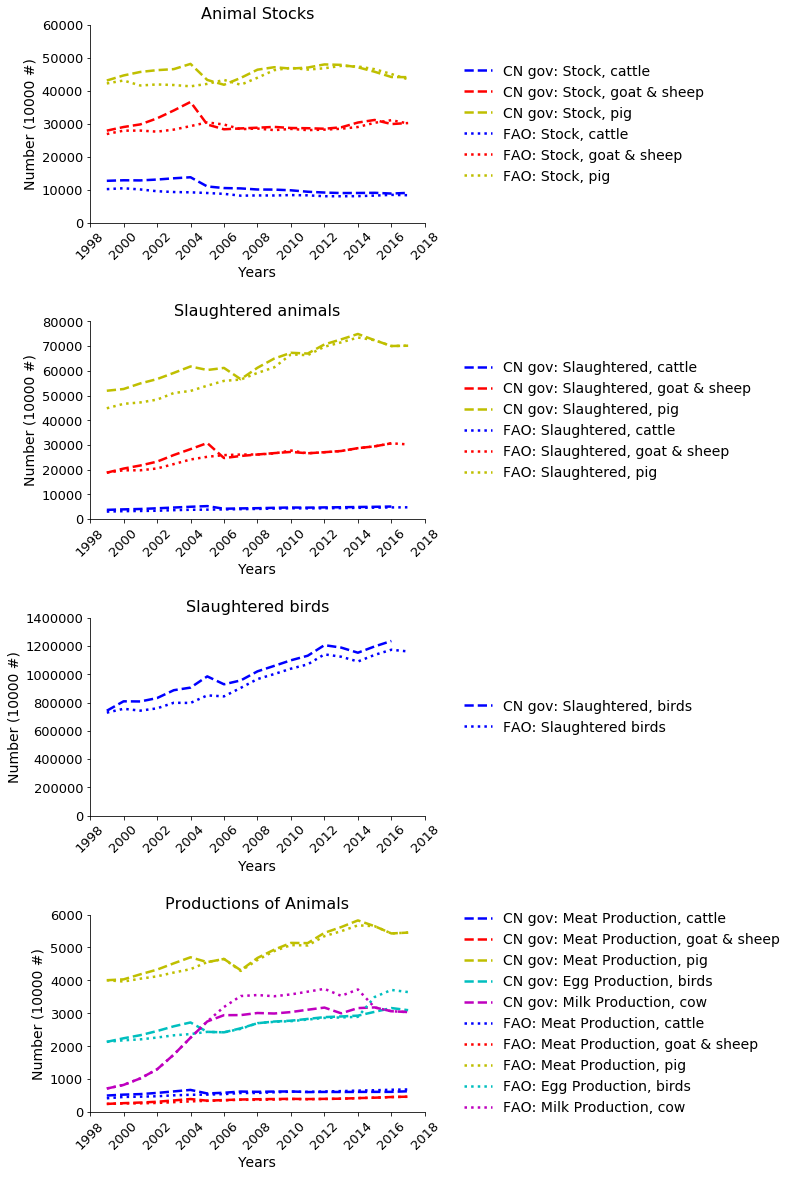

In [57]:
fig_size=(6,20)
fig = plt.figure(figsize = fig_size)
fig.tight_layout()                          
plt.subplots_adjust(wspace =0.3, hspace =0.5)

colors=('b','r','y','c','m','g')
ls1=('--','--','--','--','--','--','--') # gov
ls2=(':',':',':',':',':',':')            # fao

Xs = range(1998,2020,2)

def comparePlot(items):
    for i in range(0, len(items)):
        plt.plot(lvs_cn_cn_1999['Year'], lvs_cn_cn_1999[items[i]],c=colors[i],ls=ls1[i],lw=LIN_wei)
    for i in range(0, len(items)):
        plt.plot(lvs_fao_cn_1999['Year'], lvs_fao_cn_1999[items[i]],c=colors[i],ls=ls2[i],lw=LIN_wei)
    ax=plt.gca()
    setX_years(ax, Xs)
    setSpi_LB(ax)
#-------------------------------------------------------------------------------------------------
items = ('Stock, cattle','Stock, goat & sheep','Stock, pig')
ax0 = fig.add_subplot(4,1,1)
plt.title("Animal Stocks", fontsize=TIT_size)
comparePlot(items)
ax=plt.gca()
ax.legend(labels=['CN gov: Stock, cattle','CN gov: Stock, goat & sheep','CN gov: Stock, pig','FAO: Stock, cattle','FAO: Stock, goat & sheep','FAO: Stock, pig'],
          loc='center left', frameon=False, fontsize=LEG_size,
          bbox_to_anchor=(1.1,0.5),borderaxespad = 0.)
setY_num(ax, range(0, 70000, 10000))

items = ('Slaughtered, cattle','Slaughtered, goat & sheep','Slaughtered, pig')
ax1 = fig.add_subplot(4,1,2)
plt.title("Slaughtered animals", fontsize=TIT_size)
comparePlot(items)
'Slaughtered, cattle','Slaughtered, goat & sheep','Slaughtered, pig'
ax=plt.gca()
ax.legend(labels=['CN gov: Slaughtered, cattle','CN gov: Slaughtered, goat & sheep','CN gov: Slaughtered, pig', 'FAO: Slaughtered, cattle','FAO: Slaughtered, goat & sheep','FAO: Slaughtered, pig'],
          loc='center left', frameon=False, fontsize=LEG_size,
          bbox_to_anchor=(1.1,0.5),borderaxespad = 0.)
setY_num(ax, range(0, 90000, 10000))

ax2 = fig.add_subplot(4,1,3)
plt.title("Slaughtered birds", fontsize=TIT_size)
plt.plot(lvs_cn_cn_1999['Year'], lvs_cn_cn_1999['Slaughtered, birds'],c=colors[0],ls=ls1[0],lw=LIN_wei)
plt.plot(lvs_fao_cn_1999['Year'], lvs_fao_cn_1999['Slaughtered, birds'],c=colors[0],ls=ls2[0],lw=LIN_wei)
ax=plt.gca()
ax.legend(labels=['CN gov: Slaughtered, birds','FAO: Slaughtered birds'],
          loc='center left', frameon=False, fontsize=LEG_size,
          bbox_to_anchor=(1.1,0.5),borderaxespad = 0.)
setSpi_LB(ax)
setX_years(ax, Xs)
setY_num(ax, range(0, 1600000, 200000))

items = ('Meat Production, cattle','Meat Production, goat & sheep','Meat Production, pig','Egg Production, birds','Milk Production, cow')
ax3 = fig.add_subplot(4,1,4)
plt.title("Productions of Animals", fontsize=TIT_size)
comparePlot(items)
ax=plt.gca()
ax.legend(labels=['CN gov: Meat Production, cattle','CN gov: Meat Production, goat & sheep','CN gov: Meat Production, pig','CN gov: Egg Production, birds','CN gov: Milk Production, cow',
                  'FAO: Meat Production, cattle','FAO: Meat Production, goat & sheep','FAO: Meat Production, pig','FAO: Egg Production, birds','FAO: Milk Production, cow'],
          loc='center left', frameon=False, fontsize=LEG_size,
          bbox_to_anchor=(1.1,0.5),borderaxespad = 0.)
setY_num(ax, range(0, 7000, 1000))

plt.show()

Despite the milk data between 2005 and 2015 where the milk data from FAO is slightly higher then Chinese government, other datas are very close, and fluctuation are always happen in the same time , while FAO's data is more complete than Chinese government and has a better explanation, so we ues FAO's data as China's national data, as to different areas in China, we use Chinese government's data. 

### Merge Land Animals Datas from FAO and Chinese Government

Get the data from FAO from 1961 to 2017, and drop China's national data from Chinese government's data, and then merge the data.

In [58]:
df_fao= lvs_fao_cn[lvs_fao_cn['Year'].isin(range(1961,data_year+1))]
df_cn=lvs_cn_ars[~lvs_cn_ars['Area'].isin(['China, mainland'])]

df = pd.concat([df_fao, df_cn], join='outer', ignore_index=True, sort=False)
display(df.head())
display(df.tail())

Area  Year  Stock, cattle  Stock, goat & sheep  Stock, pig  \
0  China, mainland  1961         4940.0              11281.0      8227.0   
1  China, mainland  1962         4676.0              12387.0      7552.0   
2  China, mainland  1963         4736.0              13465.0      9997.0   
3  China, mainland  1964         4894.0              13747.0     13180.0   
4  China, mainland  1965         5242.0              13669.0     15247.0   

   Stock, birds  Slaughtered, cattle  Slaughtered, goat & sheep  \
0       62600.0                 50.6                     1000.0   
1       64200.0                 69.0                     1000.0   
2       66300.0                 92.5                     1200.0   
3       68400.0                103.5                     1400.0   
4       69000.0                116.0                     1570.0   

   Slaughtered, pig  Slaughtered, birds  Meat Production, cattle  \
0            3300.0             54500.0                      4.3   
1            4300.0             56400.0                      6.2   
2            7800.0             58000.0                      8.3   
3           10500.0             59400.0                      9.3   
4           12167.0             61600.0                     10.4   

   Meat Production, goat & sheep  Meat Production, pig  \
0                           10.0                 137.0   
1                           10.0                 178.0   
2                           12.0                 330.0   
3                           14.0                 450.0   
4                           16.0                 525.0   

   Meat Production, birds  Egg Production, birds  Milk Production, cow  \
0                   57.00                  150.0                  60.0   
1                   59.00                  152.0                  62.0   
2                   60.75                  154.0                  63.5   
3                   62.25                  158.0                  64.0   
4                   64.50                  162.0                  64.5   

   Meat Yield, cattle  Meat Yield, goat & sheep  Meat Yield, pig  \
0                85.0                 10.000000             41.5   
1                89.9                 10.000000             41.4   
2                89.7                 10.000000             42.3   
3                89.9                 10.000000             42.9   
4                89.7                 10.191083             43.1   

   Meat Yield, birds  
0           1.045872  
1           1.046099  
2           1.047414  
3           1.047980  
4           1.047078

Area  Year  Stock, cattle  Stock, goat & sheep  Stock, pig  \
672   Shaanxi  2017     151.232020           868.520960  854.423760   
673     Gansu  2017     424.311515          1839.887280  551.320000   
674   Qinghai  2017     546.560000          1387.410000   82.680000   
675   Ningxia  2017     118.333400           506.589363   81.035057   
676  Xinjiang  2017     432.988327          4317.919646  342.682280   

     Stock, birds  Slaughtered, cattle  Slaughtered, goat & sheep  \
672           NaN                  NaN                        NaN   
673           NaN                  NaN                        NaN   
674           NaN                  NaN                        NaN   
675           NaN                  NaN                        NaN   
676           NaN                  NaN                        NaN   

     Slaughtered, pig  Slaughtered, birds  Meat Production, cattle  \
672       1141.013664                 NaN                 8.332958   
673        682.730000                 NaN                20.961000   
674        110.630000                 NaN                12.860000   
675        113.745445                 NaN                10.917891   
676        495.765348                 NaN                43.040014   

     Meat Production, goat & sheep  Meat Production, pig  \
672                       9.800000             85.834229   
673                      22.758000             49.882000   
674                      12.680000              8.670000   
675                       9.906033              8.907976   
676                      58.241447             35.802410   

     Meat Production, birds  Egg Production, birds  Milk Production, cow  \
672                     NaN              60.082440            107.275087   
673                     NaN              13.830500             40.400000   
674                     NaN               2.460000             32.427941   
675                     NaN              15.271177            160.065904   
676                     NaN              37.373828            191.860000   

     Meat Yield, cattle  Meat Yield, goat & sheep  Meat Yield, pig  \
672                 NaN                       NaN              NaN   
673                 NaN                       NaN              NaN   
674                 NaN                       NaN              NaN   
675                 NaN                       NaN              NaN   
676                 NaN                       NaN              NaN   

     Meat Yield, birds  
672                NaN  
673                NaN  
674                NaN  
675                NaN  
676                NaN

In [59]:
df.to_csv('./data/'+'product'+'_temp.csv', index=False)

### Merge Aquatic Data to Land Animals' Data

In [60]:
aqu = pd.read_csv('./data/'+'aqu'+'_temp.csv')
df = pd.read_csv('./data/'+'product'+'_temp.csv')

df = pd.merge(df,aqu,how='outer',on=('Area','Year'))

print(df.shape)
display(df.head())
display(df.tail())

(677, 37)


Area  Year  Stock, cattle  Stock, goat & sheep  Stock, pig  \
0  China, mainland  1961         4940.0              11281.0      8227.0   
1  China, mainland  1962         4676.0              12387.0      7552.0   
2  China, mainland  1963         4736.0              13465.0      9997.0   
3  China, mainland  1964         4894.0              13747.0     13180.0   
4  China, mainland  1965         5242.0              13669.0     15247.0   

   Stock, birds  Slaughtered, cattle  Slaughtered, goat & sheep  \
0       62600.0                 50.6                     1000.0   
1       64200.0                 69.0                     1000.0   
2       66300.0                 92.5                     1200.0   
3       68400.0                103.5                     1400.0   
4       69000.0                116.0                     1570.0   

   Slaughtered, pig  Slaughtered, birds  Meat Production, cattle  \
0            3300.0             54500.0                      4.3   
1            4300.0             56400.0                      6.2   
2            7800.0             58000.0                      8.3   
3           10500.0             59400.0                      9.3   
4           12167.0             61600.0                     10.4   

   Meat Production, goat & sheep  Meat Production, pig  \
0                           10.0                 137.0   
1                           10.0                 178.0   
2                           12.0                 330.0   
3                           14.0                 450.0   
4                           16.0                 525.0   

   Meat Production, birds  Egg Production, birds  Milk Production, cow  \
0                   57.00                  150.0                  60.0   
1                   59.00                  152.0                  62.0   
2                   60.75                  154.0                  63.5   
3                   62.25                  158.0                  64.0   
4                   64.50                  162.0                  64.5   

   Meat Yield, cattle  Meat Yield, goat & sheep  Meat Yield, pig  \
0                85.0                 10.000000             41.5   
1                89.9                 10.000000             41.4   
2                89.7                 10.000000             42.3   
3                89.9                 10.000000             42.9   
4                89.7                 10.191083             43.1   

   Meat Yield, birds  Aquatic, total  Aquatic, animals  Marine, total  \
0           1.045872             NaN               NaN            NaN   
1           1.046099             NaN               NaN            NaN   
2           1.047414             NaN               NaN            NaN   
3           1.047980             NaN               NaN            NaN   
4           1.047078             NaN               NaN            NaN   

   Marine, capture  Marine, aquac.  Marine Fish  Marine Crustaceans  \
0              NaN             NaN          NaN                 NaN   
1              NaN             NaN          NaN                 NaN   
2              NaN             NaN          NaN                 NaN   
3              NaN             NaN          NaN                 NaN   
4              NaN             NaN          NaN                 NaN   

   Marine Molluscs  Marine Plants  Marine, others  Freshwater, total  \
0              NaN            NaN             NaN                NaN   
1              NaN            NaN             NaN                NaN   
2              NaN            NaN             NaN                NaN   
3              NaN            NaN             NaN                NaN   
4              NaN            NaN             NaN                NaN   

   Freshwater, capture  Freshwater, aquac.  Freshwater Fish  \
0                  NaN                 NaN              NaN   
1                  NaN                 NaN              NaN   
2                  NaN                 NaN            

Area  Year  Stock, cattle  Stock, goat & sheep  Stock, pig  \
672   Shaanxi  2017     151.232020           868.520960  854.423760   
673     Gansu  2017     424.311515          1839.887280  551.320000   
674   Qinghai  2017     546.560000          1387.410000   82.680000   
675   Ningxia  2017     118.333400           506.589363   81.035057   
676  Xinjiang  2017     432.988327          4317.919646  342.682280   

     Stock, birds  Slaughtered, cattle  Slaughtered, goat & sheep  \
672           NaN                  NaN                        NaN   
673           NaN                  NaN                        NaN   
674           NaN                  NaN                        NaN   
675           NaN                  NaN                        NaN   
676           NaN                  NaN                        NaN   

     Slaughtered, pig  Slaughtered, birds  Meat Production, cattle  \
672       1141.013664                 NaN                 8.332958   
673        682.730000                 NaN                20.961000   
674        110.630000                 NaN                12.860000   
675        113.745445                 NaN                10.917891   
676        495.765348                 NaN                43.040014   

     Meat Production, goat & sheep  Meat Production, pig  \
672                       9.800000             85.834229   
673                      22.758000             49.882000   
674                      12.680000              8.670000   
675                       9.906033              8.907976   
676                      58.241447             35.802410   

     Meat Production, birds  Egg Production, birds  Milk Production, cow  \
672                     NaN              60.082440            107.275087   
673                     NaN              13.830500             40.400000   
674                     NaN               2.460000             32.427941   
675                     NaN              15.271177            160.065904   
676                     NaN              37.373828            191.860000   

     Meat Yield, cattle  Meat Yield, goat & sheep  Meat Yield, pig  \
672                 NaN                       NaN              NaN   
673                 NaN                       NaN              NaN   
674                 NaN                       NaN              NaN   
675                 NaN                       NaN              NaN   
676                 NaN                       NaN              NaN   

     Meat Yield, birds  Aquatic, total  Aquatic, animals  Marine, total  \
672                NaN         16.3030           16.3030            0.0   
673                NaN          1.5441            1.5441            0.0   
674                NaN          1.6073            1.6073            0.0   
675                NaN         18.0889           18.0889            0.0   
676                NaN         16.5528           16.5528            0.0   

     Marine, capture  Marine, aquac.  Marine Fish  Marine Crustaceans  \
672              0.0             0.0          0.0                 0.0   
673              0.0             0.0          0.0                 0.0   
674              0.0             0.0          0.0                 0.0   
675              0.0             0.0          0.0                 0.0   
676              0.0             0.0          0.0                 0.0   

     Marine Molluscs  Marine Plants  Marine, others  Freshwater, total  \
672              0.0            0.0             0.0            16.3030   
673              0.0            0.0             0.0             1.5441   
674              0.0            0.0             0.0             1.6073   
675              0.0            0.0             0.0            18.0889   
676              0.0            0.0             0.0            16.5528   

     Freshwater, capture  Freshwater, aquac.  Freshwater Fish  \
672               0.7200             15.5830          15.6488   
673               0.0000              1.54

## Estimating Some Missing Values of Areas' Data

- **For cattle, goat & sheep, and pig Unit Meat Yilds in China's areas:**

    - *'Meat Yield, cattle' = 'Meat Production, cattle' / 'Slaughtered, cattle'*
    - *'Meat Yield, goat & sheep' = 'Meat Production, goat & sheep' / 'Slaughtered, goat & sheep'*
    - *'Meat Yield, pig' = 'Meat Production, pig' / 'Slaughtered, pig'*


- **For birds' unit meat yields, meat productions and stocks in China's Area:**

    - Birds Unit Meat Yilds in China's areas:

    Lacking of Meat 'Production, birds' and 'Slaughtered, birds', 'Meat Yield, birds' can be replaced with the national data in the same year.
    
    - Birds Stocks:
    
    *(each year's 'Slaughtered, birds' of cn / each year's 'Stock, birds' of cn) = ('Slaughtered, birds' in areas of same year / 'Stock, birds' in areas of same year)*
    
    - Birds Meat Productions:
    
    *'Meat Production, birds' = 'Meat Yield, birds' * 'Slaughtered, birds'*
    

In [61]:
# cattle, goat & sheep, pig
df.loc[~df['Area'].isin(['China, mainland']), 'Meat Yield, cattle'] = df['Meat Production, cattle']/df['Slaughtered, cattle']*1000 # 吨到千克
df.loc[~df['Area'].isin(['China, mainland']), 'Meat Yield, goat & sheep'] = df['Meat Production, goat & sheep']/df['Slaughtered, goat & sheep']*1000
df.loc[~df['Area'].isin(['China, mainland']), 'Meat Yield, pig'] = df['Meat Production, pig']/df['Slaughtered, pig']*1000 

# birds
Years = range(1999,data_year)
Areas = list(df['Area'].unique())
Areas.remove('China, mainland')
for y in Years:
    for area in Areas:
        # Birds Unit Meat Yilds in China's areas
        df.loc[(df['Area']==area) & (df['Year']==y), 'Meat Yield, birds'] \
        = df[(df['Area']=='China, mainland') & (df['Year']==2016)]['Meat Yield, birds'].values[0]
        # for Birds Stocks 
        df.loc[(df['Area']==area) & (df['Year']==y), 'St/Sl, birds, est']\
        = df[(df['Area']=='China, mainland') & (df['Year']==y)]['Stock, birds'].values[0]\
        / df[(df['Area']=='China, mainland') & (df['Year']==y)]['Slaughtered, birds'].values[0]
# Birds stock
df.loc[~df['Area'].isin(['China, mainland']), 'Stock, birds'] = df['St/Sl, birds, est'] * df['Slaughtered, birds']
# Birds Meat Productions
df.loc[~df['Area'].isin(['China, mainland']), 'Meat Production, birds'] = df['Slaughtered, birds'] * df['Meat Yield, birds'] * 10000 / 10000000 # 万只，千克到万吨

df.drop(columns=(['St/Sl, birds, est']), inplace=True)
display(df[df['Area']=='Beijing'].head())
display(df[df['Area']=='Beijing'].tail())
display(df.shape)

Area  Year  Stock, cattle  Stock, goat & sheep  Stock, pig  \
57   Beijing  1998          12.50                95.80  254.500000   
88   Beijing  1999          13.60               103.10  248.300000   
119  Beijing  2000          18.85               120.11  250.050000   
150  Beijing  2001          23.40               145.10  248.200000   
181  Beijing  2002          27.43               175.24  277.828661   

     Stock, birds  Slaughtered, cattle  Slaughtered, goat & sheep  \
57            NaN                  NaN                        NaN   
88    5725.555784                13.50                      88.20   
119   7574.967307                17.27                     103.93   
150  10716.356322                22.90                     201.20   
181  10037.192980                26.81                     263.88   

     Slaughtered, pig  Slaughtered, birds  Meat Production, cattle  \
57          374.80000                 NaN                   2.1000   
88          400.90000            10850.30                   2.4000   
119         415.61000            13986.90                   3.2681   
150         453.10000            18646.46                   4.0118   
181         483.18428            16385.89                   4.9220   

     Meat Production, goat & sheep  Meat Production, pig  \
57                         1.20000               27.9000   
88                         1.30000               28.6000   
119                        1.55895               29.0927   
150                        3.01750               31.1951   
181                        4.24420               33.8229   

     Meat Production, birds  Egg Production, birds  Milk Production, cow  \
57                      NaN                17.9000               22.7000   
88                14.556703                15.8000               24.0000   
119               18.764748                16.0000               30.3312   
150               25.015989                15.5587               42.9004   
181               21.983220                15.2145               55.0805   

     Meat Yield, cattle  Meat Yield, goat & sheep  Meat Yield, pig  \
57                  NaN                       NaN        74.439701   
88           177.777778                 14.739229        71.339486   
119          189.235669                 15.000000        70.000000   
150          175.187773                 14.997515        68.848157   
181          183.588213                 16.083826        70.000000   

     Meat Yield, birds  Aquatic, total  Aquatic, animals  Marine, total  \
57                 NaN          7.6400            7.6400            0.0   
88            1.341595          7.5600            7.5600            0.0   
119           1.341595          7.5044            7.5044            0.0   
150           1.341595          7.4302            7.4302            0.0   
181           1.341595          7.4168            7.4168            0.0   

     Marine, capture  Marine, aquac.  Marine Fish  Marine Crustaceans  \
57               0.0             0.0          0.0                 0.0   
88               0.0             0.0          0.0                 0.0   
119              0.0             0.0          0.0                 0.0   
150              0.0             0.0          0.0                 0.0   
181              0.0             0.0          0.0                 0.0   

     Marine Molluscs  Marine Plants  Marine, others  Freshwater, total  \
57               0.0            0.0             0.0             7.6400   
88               0.0            0.0             0.0             7.5600   
119              0.0            0.0             0.0             7.5044   
150              0.0            0.0             0.0             7.4302   
181              0.0            0.0             0.0             7.4168   

     Freshwater, capture  Freshwater, aquac.  Freshwater Fish  \
57                   0.0              7.6400          7.60000   
88                   0.0              7.5600   

Area  Year  Stock, cattle  Stock, goat & sheep  Stock, pig  \
522  Beijing  2013        20.3500              59.4700    189.2300   
553  Beijing  2014        19.6800              68.3500    179.6000   
584  Beijing  2015        17.4848              69.3511    165.6081   
615  Beijing  2016        16.1556              59.6194    165.3117   
646  Beijing  2017        12.8312              35.1815    112.1828   

     Stock, birds  Slaughtered, cattle  Slaughtered, goat & sheep  \
522   4112.070691                 11.2                       70.8   
553   3593.193788                  9.2                       68.7   
584   3104.117963                  8.4                       71.0   
615   1878.096831                  7.4                       69.6   
646           NaN                  NaN                        NaN   

     Slaughtered, pig  Slaughtered, birds  Meat Production, cattle  \
522          314.3900              8529.8                 2.050000   
553          305.7600              7550.7                 1.700000   
584          284.4164              6688.4                 1.546100   
615          275.3386              3882.7                 1.360064   
646          242.0685                 NaN                 1.474351   

     Meat Production, goat & sheep  Meat Production, pig  \
522                       1.193670             24.630000   
553                       1.170000             24.010000   
584                       1.195500             22.478200   
615                       1.164135             21.841667   
646                       1.055821             19.218211   

     Meat Production, birds  Egg Production, birds  Milk Production, cow  \
522               11.443533              17.500000             61.460000   
553               10.129978              19.650000             59.480000   
584                8.973121              19.580000             57.215500   
615                5.209009              18.333386             45.695278   
646                     NaN              15.684737             37.421293   

     Meat Yield, cattle  Meat Yield, goat & sheep  Meat Yield, pig  \
522          183.035714                 16.859746        78.342186   
553          184.782609                 17.030568        78.525641   
584          184.059524                 16.838028        79.032714   
615          183.792432                 16.726078        79.326571   
646                 NaN                       NaN        79.391623   

     Meat Yield, birds  Aquatic, total  Aquatic, animals  Marine, total  \
522           1.341595          6.3611            6.3611         0.7008   
553           1.341595          6.8184            6.8184         1.3222   
584           1.341595          6.6147            6.6147         1.7000   
615           1.341595          5.4288            5.4288         1.3514   
646                NaN          4.5098            4.5098         0.9000   

     Marine, capture  Marine, aquac.  Marine Fish  Marine Crustaceans  \
522           0.7008             0.0       0.7008                 0.0   
553           1.3222             0.0       1.3222                 0.0   
584           1.7000             0.0       1.7000                 0.0   
615           1.3514             0.0       1.3514                 0.0   
646           0.9000             0.0       0.9000                 0.0   

     Marine Molluscs  Marine Plants  Marine, others  Freshwater, total  \
522              0.0            0.0             0.0             5.6603   
553              0.0            0.0             0.0             5.4962   
584              0.0            0.0             0.0             4.9147   
615              0.0            0.0             0.0             4.0774   
646              0.0            0.0             0.0             3.6098   

     Freshwater, capture  Freshwater, aquac.  Freshwater Fish  \
522               0.3691              5.2912           5.6359   
553               0.4091              5.0871   

(677, 37)

## Save Clean Data and Delete Temp Data

In [62]:
df.to_csv('./data/hybrid/MeatProduction_clean.csv', index=False)

In [65]:
fls = os.listdir('./data/')
for f in fls:
    if 'temp' in f:
        os.remove('./data/'+f)